# Bioduomenų surinkimas ir analizė

## Kolis Nr.6 2023-04-11

Sprendimus siųskite (vardas_pavarde_k6.ipynb; ipynb ir pdf/html formatais)
iki 2023-04-16 23:55 į avoicikas@gmail.com

Įveskite savo vardą ir pavardę

Vertinimas

- Komentarai kodo ir planas veiksmų 25 %
- Programos kodas (algoritmų įgyvendinimas) 25 %
- Grafikai ir lentelės (tvarka) 25 %
- Rezultatas (Istorija aprašanti gautus grafikus, lenteles) 25 %


---
>> **UŽDUOTIS 1**
>>
>> Akių judesių aptikimas ([EOG](https://en.wikipedia.org/wiki/Electrooculography))
>>
>> EOG direktorijoje pateikti įrašai xEOG.csv kur x yra dalyvio numeris.
>>
>> Pirmas stulpelis - EOG vertikalūs elektrodai (V)
>>
>> Antras stulpelis - EOG horizontalūs elektrodai (V)
>>
>> Trečias stulpelis - laikas (ms)
>>
>> Užduotys:
>> - **Sutvarkykite duomenis, automatizuokite duomenų analizę.**
>> - **Aptikite vertikalius akių judesius.**
>> - **Aptikite horizontalius akių judesius.**
>> - **Suskaičiuokite EOG parametrus (vidutinę amplitudę, mirksnių dažnį), vizualizuokite ir užsaugokite rezultatus csv faile.**
>> - **Nubraižyti vidutinį individualų mirksnį.**
>> - **Nubraižyti vidutinį bendrą mirksnį.**
>> - **Grafikus užsaugoti png formatu**
>>
>>
>> EOG.pdf apibūdina detaliai EOG aptikimą ir bendrą EOG morfologiją (Nereikia pakartoti, tai papildoma informacija aiškumui).
>>
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft, fftshift
import stockwell as smt
from scipy import stats
from scipy import sparse
from scipy.sparse.linalg import spsolve
import os as os
import neurokit2 as nk
import peakutils

In [2]:
directory=r"C:\Users\taura\Documents\biod2022\exam\K6\EOG"
#AUTOMOTIZUOTAS DUOMENU IMPORTINIMAS IR APTVARKYMAS - DUOMETRONAS !!!!!
dataframes = {}
def duometronas(directory=directory):
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.DataFrame(pd.read_csv(file_path, index_col=2))
            df.columns=["EOG vertikalūs elektrodai (V)","EOG horizontalūs elektrodai (V)"]
            df.index.rename("Time, (ms)")
            #Slicinu purvinus duomenis
            df=df[8000:35000]
            dataframes[file] = df
            
duometronas()

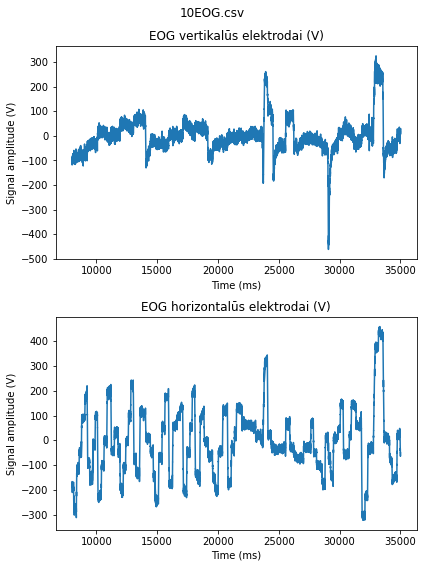

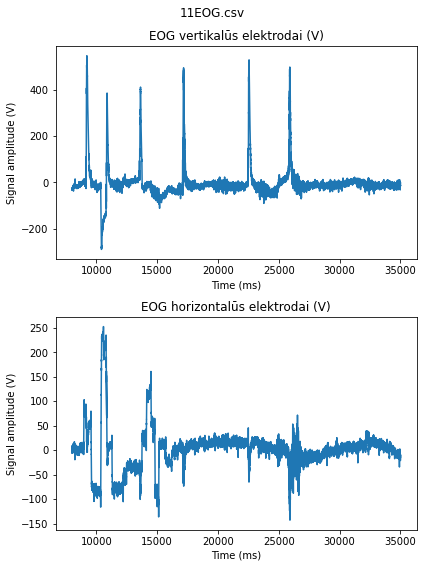

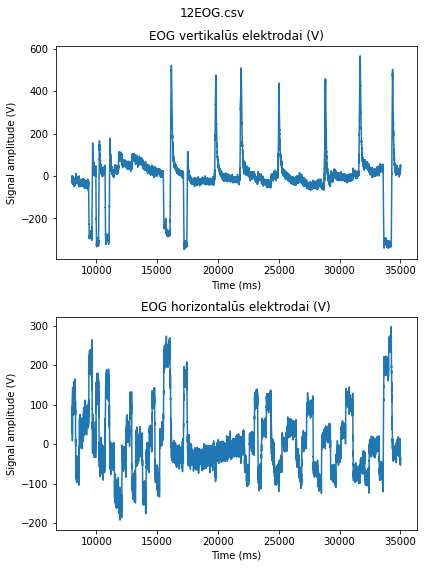

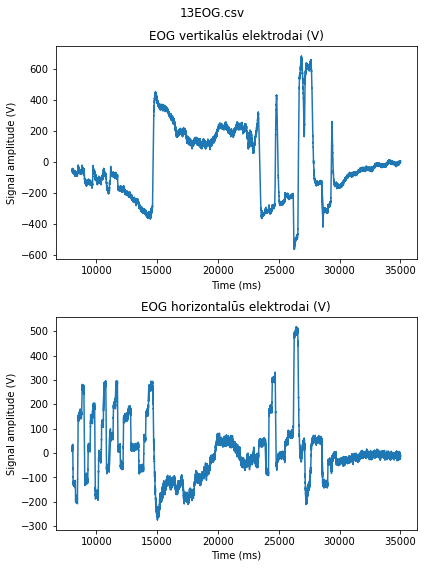

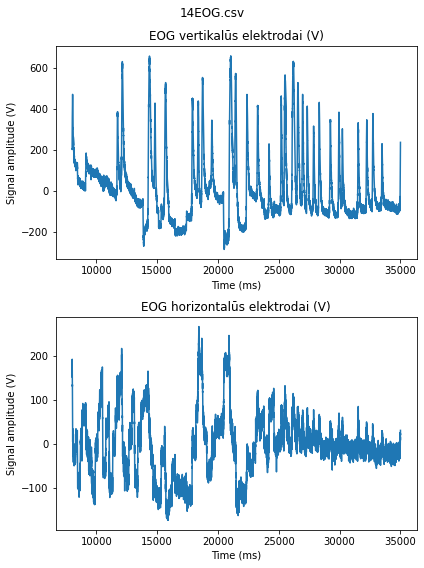

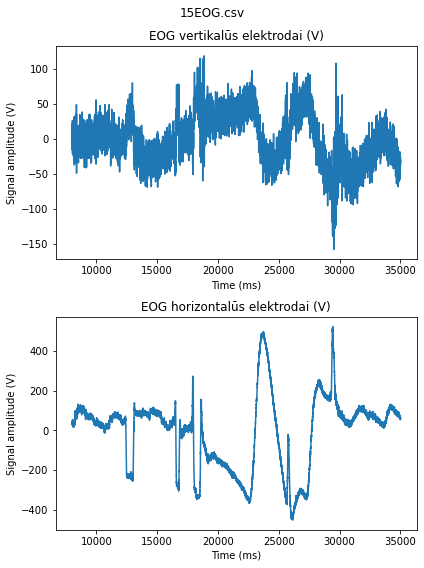

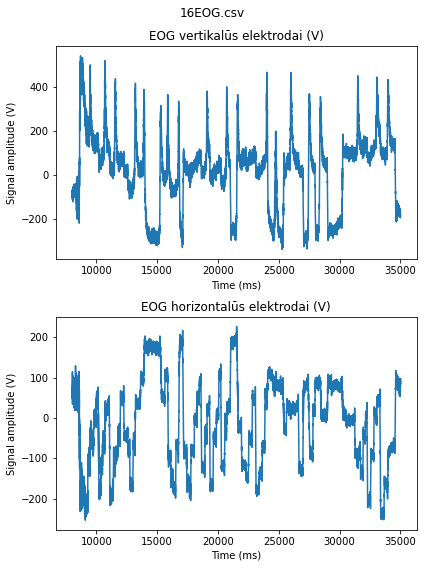

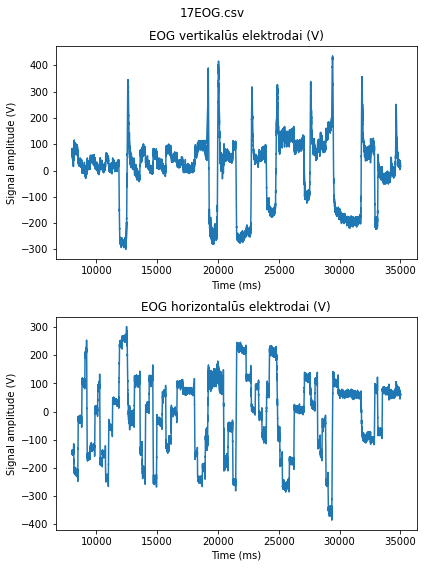

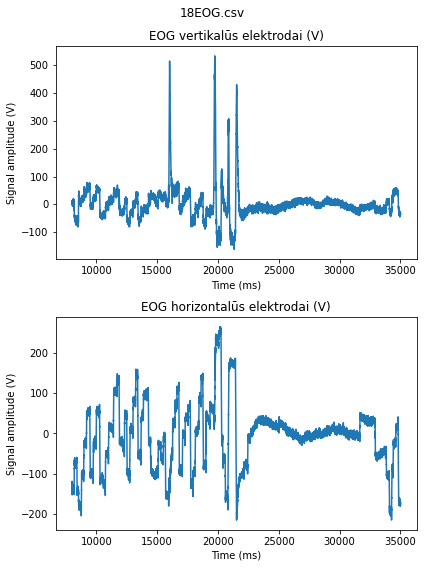

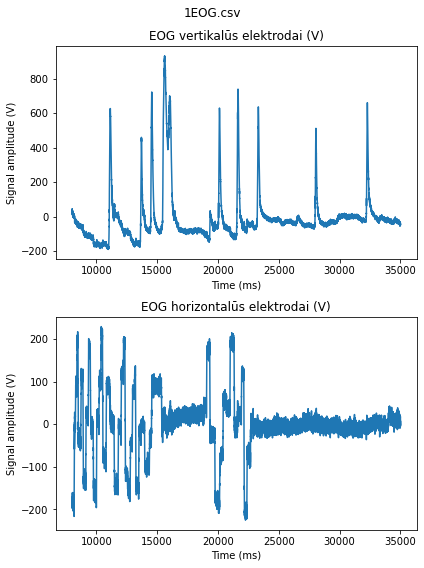

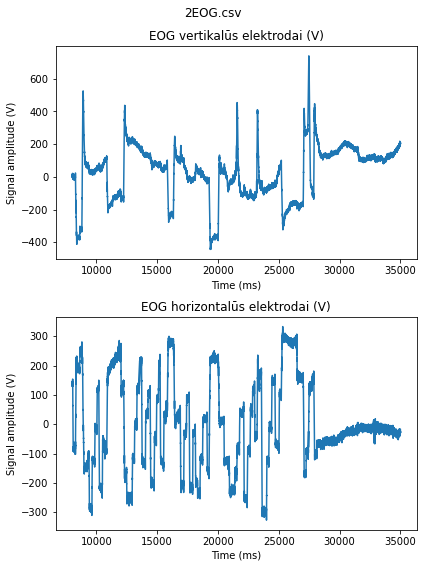

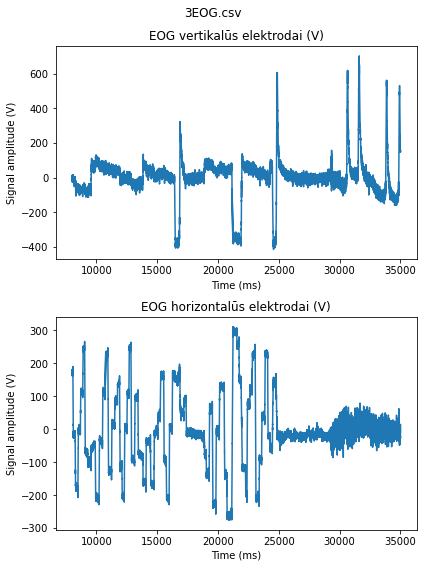

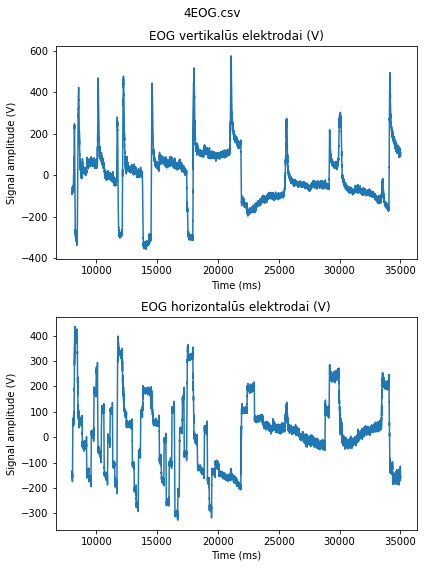

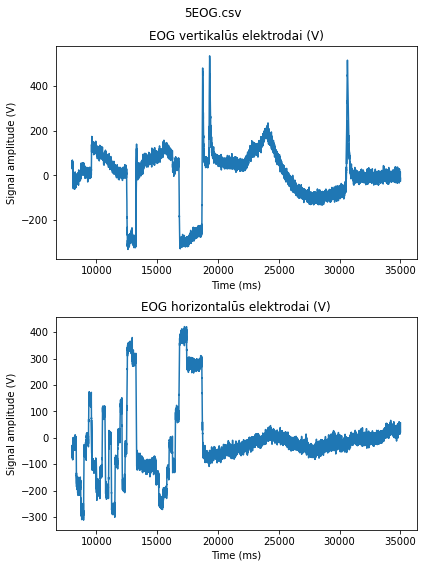

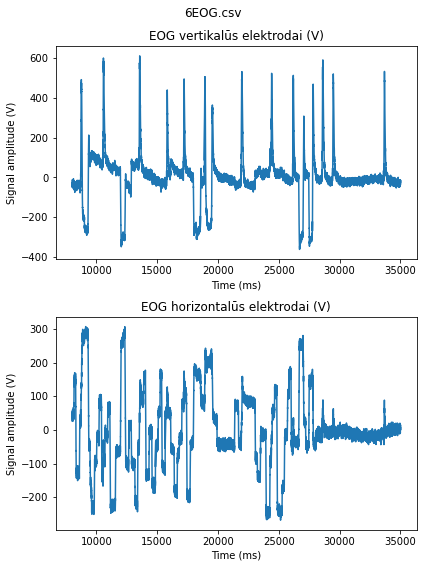

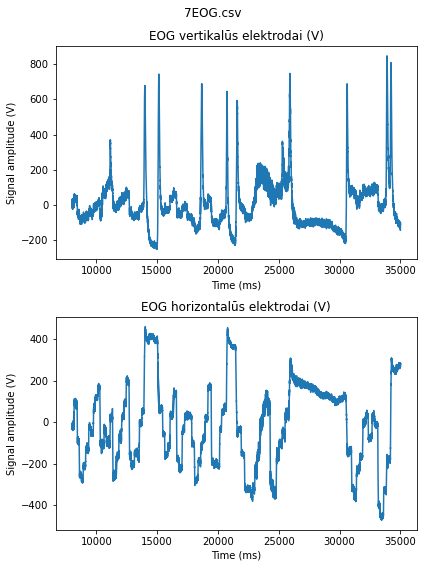

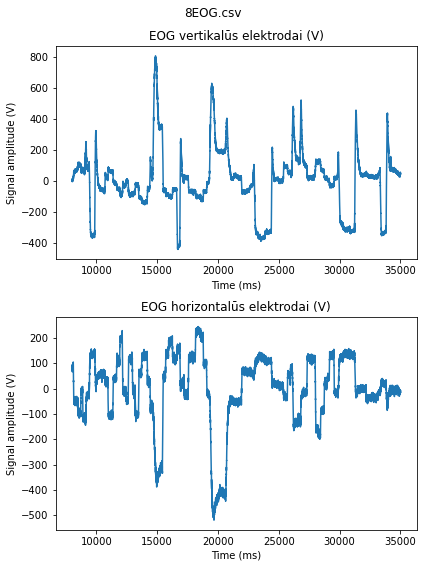

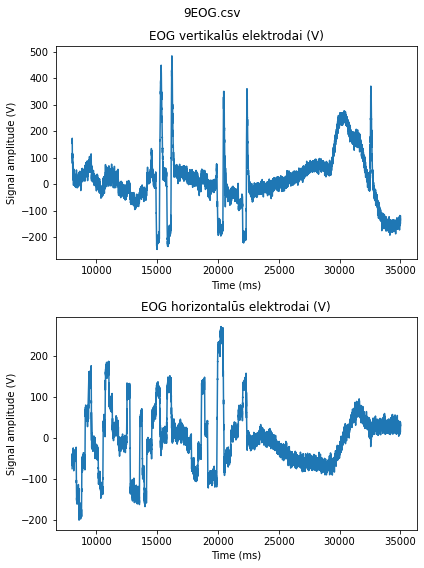

In [3]:
#Grafikai kiekvienam  duomeniui
for name in dataframes:
    fig, axes = plt.subplots(nrows=len(dataframes[name].columns), figsize=(6, 8))
    fig.suptitle(name)
    for i, col in enumerate(dataframes[name].columns):
        axes[i].plot(dataframes[name][col])
        axes[i].set_xlabel("Time (ms)")
        axes[i].set_ylabel("Signal amplitude (V)")
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

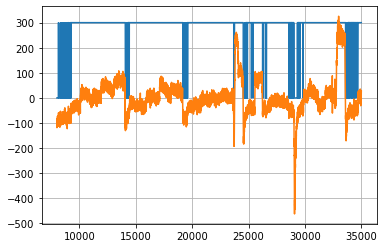

In [4]:
#PAVYZDYS KAIP SKAICIUOTI PAJUDEJIMUS, paverciant signala i binary
#PAdaryti tai kiekvienam plotui ir tada suskaiciuoti peakus - taip gausim visu horizantaliu ir vertikaliu peaku judesius.
df=dataframes['10EOG.csv']["EOG vertikalūs elektrodai (V)"]
binary = nk.signal_binarize(df)
plt.grid(visible=True, which='major', axis='both')
plt.plot(binary*300)
plt.plot(df)

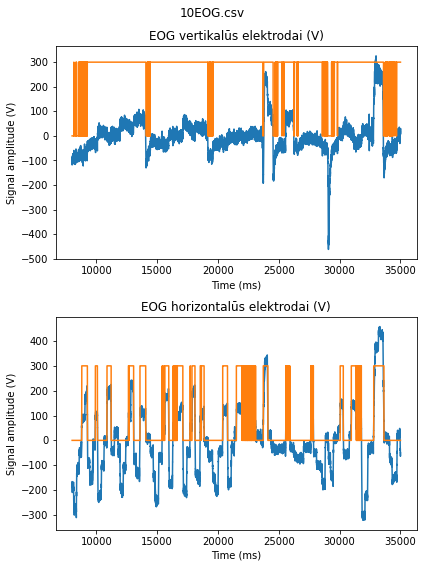

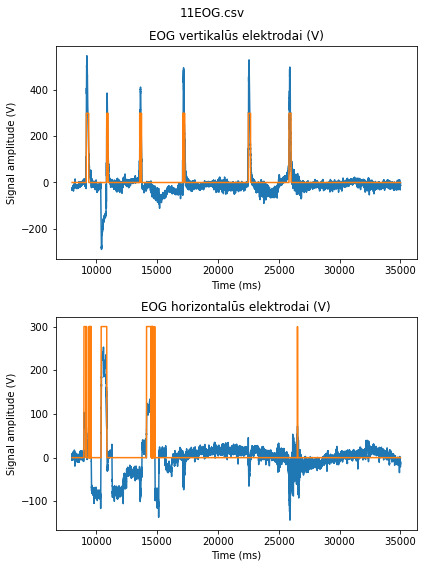

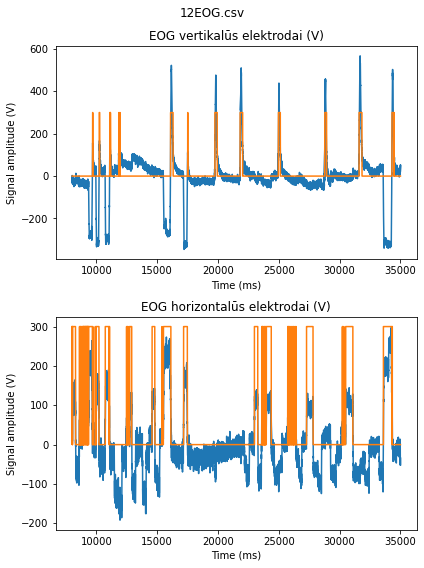

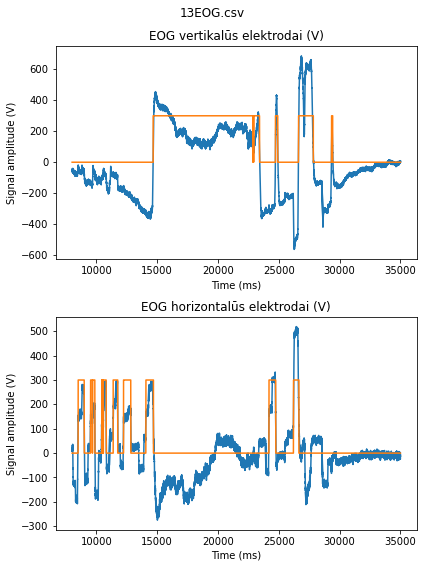

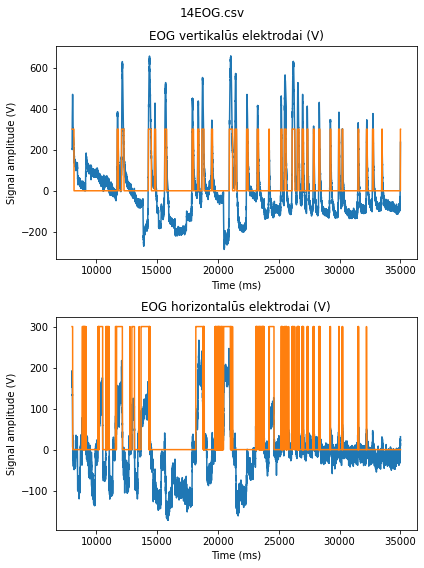

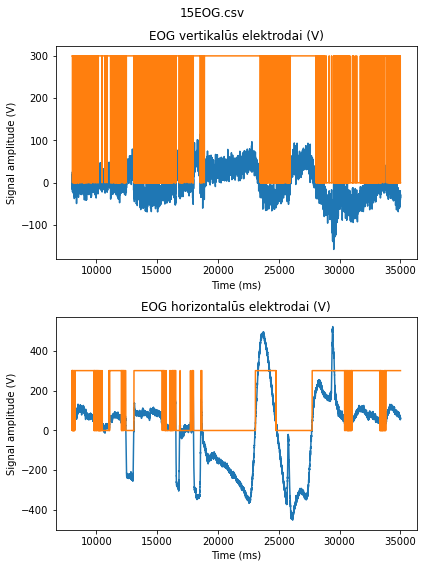

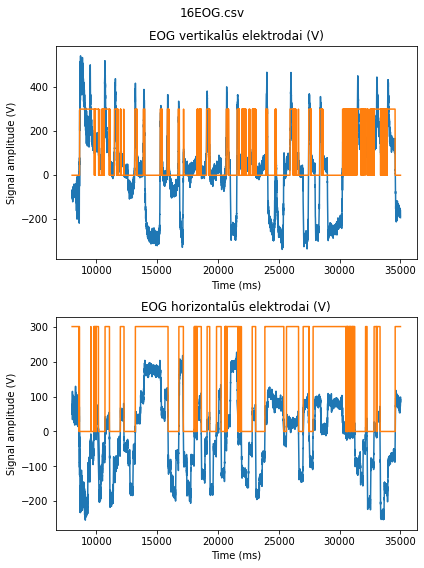

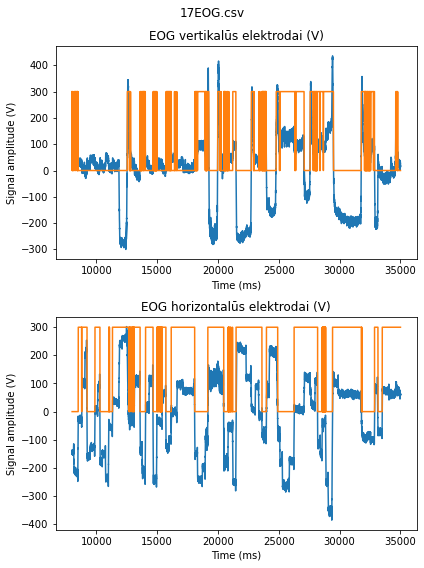

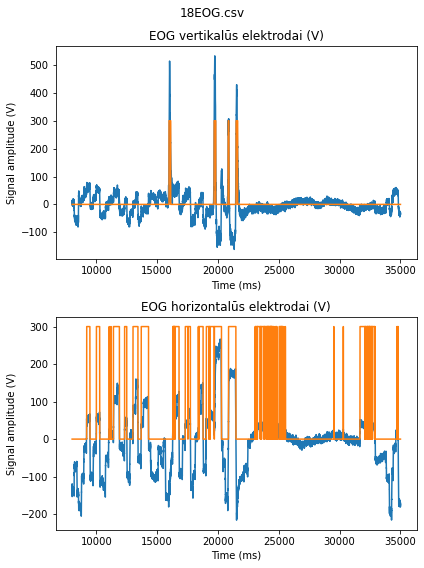

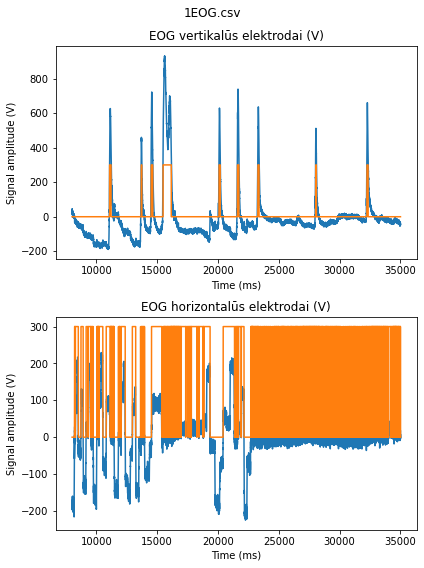

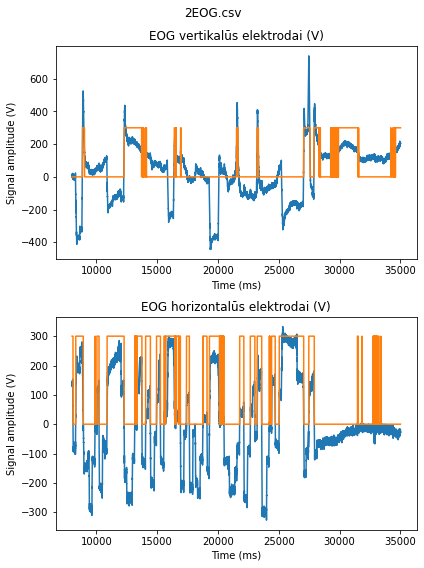

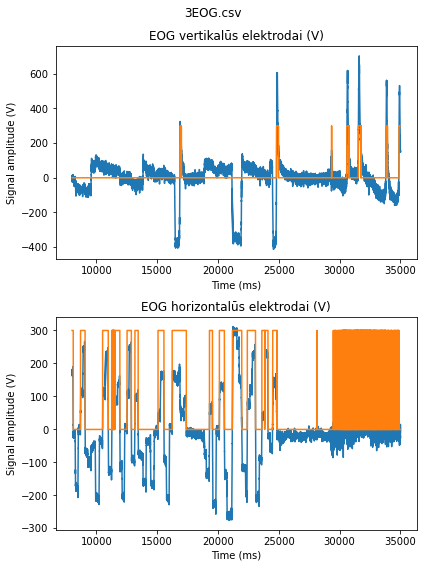

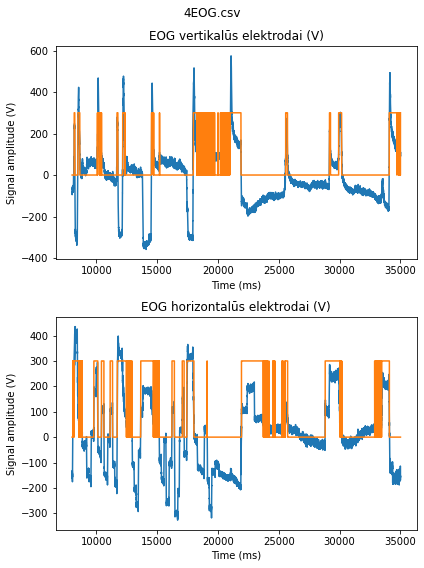

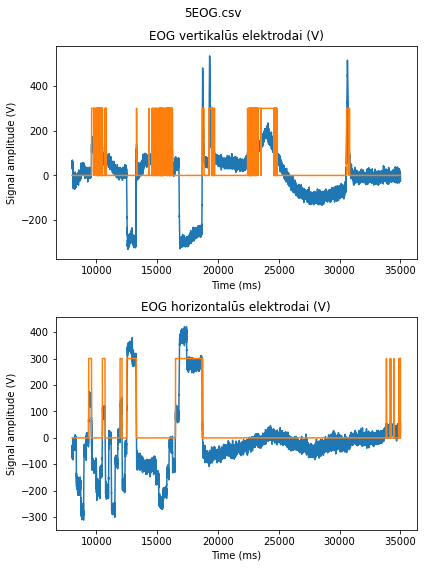

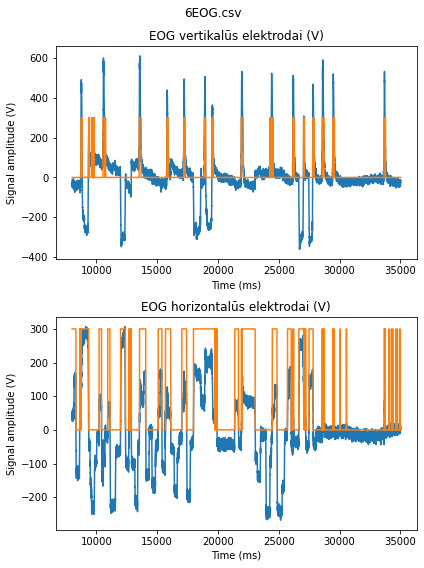

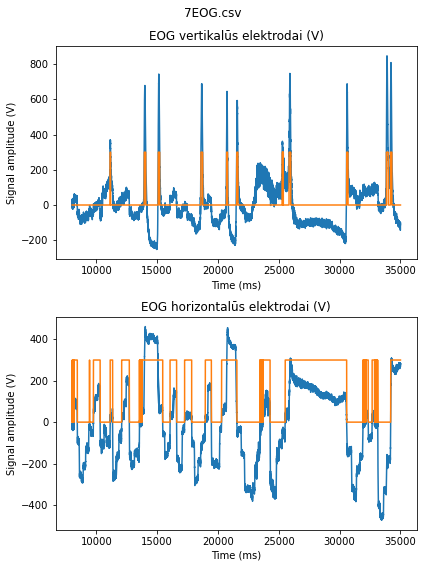

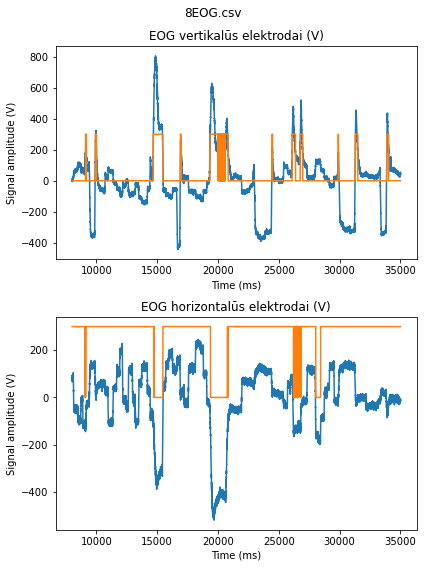

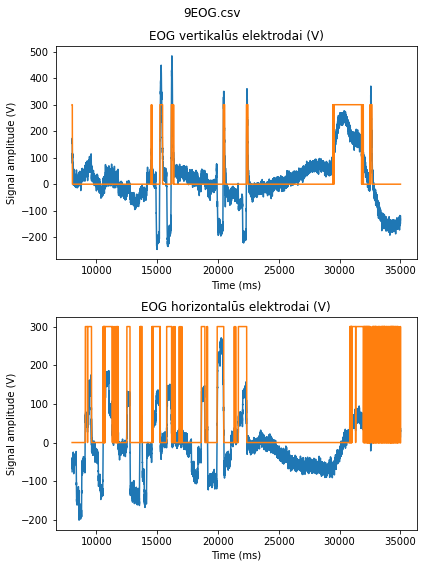

In [5]:
#Pavaizdavau peakais visus horizontalius ir vertikalius peakus.

for name in dataframes:
    fig, axes = plt.subplots(nrows=len(dataframes[name].columns), figsize=(6, 8))
    fig.suptitle(name)
    for i, col in enumerate(dataframes[name].columns):
        axes[i].plot(dataframes[name][col])
        axes[i].plot(nk.signal_binarize(dataframes[name][col])*300)
        axes[i].set_xlabel("Time (ms)")
        axes[i].set_ylabel("Signal amplitude (V)")
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

In [6]:
#Skaiciuojant realu mirksniu dazni suskaiciuosim binary-izuoto signalo peakus ir padalinsim / laiko overall
#for name in dataframes:
    #for i, col in enumerate(dataframes[name].columns):
        #binarized =signal.find_peaks_cwt(nk.signal_binarize(dataframes[name][col]),widths=np.arange(1, 100))#naudojame cia find_peak_cwt nes jis gaudo sparcius verciu pokycius
        #count_ones = binarized.sum()
       # print(f"DataFrame: {name}, Column: {col}, Number of ones: {count_ones}")
        # GERAI, teoriskai butu viskas tvarkoje ir as dabar paimciau count ones ir padalinciau is times ir gauciau teisinga mirksniu dazni.Bet mechanizmas labai sunkiai ir keistai veikia. 
        #Bet tolimesnis kodas butu paprastas
        #Mirksniu daznis :
        #mirkdazn=(count_ones / dataframe.index)*1000 # paverciam i sekundes
        

In [7]:
#Vidutine amplitude:
#pasiimsim visus laiko taskus kur binary signalas yra lygus 1 ir skaiciuosim vidutine verte
laiko_momentai={}
y_vertes={}
for name in dataframes:
    for i, col in enumerate(dataframes[name].columns):
        binarized = nk.signal_binarize(dataframes[name][col])
        laiko_momentai[name] = binarized[binarized == 1]
        #Itartinai sudetingas budas bet cia tesiog referencinu y vertes ant gautu x laiku
    df_index = laiko_momentai[name].index
    y_vertes[name]=dataframes[name].loc[df_index]

In [8]:
#Gautos visos y vertes kur buvo buvo vyko mirksnis
#print(y_vertes)
#gauname amplitude skaiciuodamai arg min ir arg max kiekvienu sitame sarase esanciu y verciu
minverte=[]
maxverte=[]
for name in dataframes:
    for i, col in enumerate(dataframes[name].columns):
        minverteb = dataframes[name][col].argmin()
        maxverteb = dataframes[name][col].argmax()
        minverte.append(minverteb)
        maxverte.append(maxverteb)
        mina=dataframes[name][col].iloc[minverte].reset_index()
        maxa=dataframes[name][col].iloc[maxverte].reset_index()
        amplitude = abs(maxa - mina)

In [9]:
keys = list(dataframes.keys())
keys

['10EOG.csv',
 '11EOG.csv',
 '12EOG.csv',
 '13EOG.csv',
 '14EOG.csv',
 '15EOG.csv',
 '16EOG.csv',
 '17EOG.csv',
 '18EOG.csv',
 '1EOG.csv',
 '2EOG.csv',
 '3EOG.csv',
 '4EOG.csv',
 '5EOG.csv',
 '6EOG.csv',
 '7EOG.csv',
 '8EOG.csv',
 '9EOG.csv']

In [10]:
#Amplitude aprasantis Dataframas
amplitude.index = ['10EOG-V','10EOG-H','11EOG-H','11EOG-V','12EOG-H','12EOG-V', '13EOG-V','13EOG-H','14EOG-V','14EOG-H','15EOG-V','15EOG-H','16EOG-V','16EOG-H','17EOG-V','17EOG-H','18EOG-V','18EOG-H','1EOG-V','1EOG-H','2EOG-V','2EOG-H','3EOG-V','3EOG-H','4EOG-V','4EOG-H','5EOG-V','5EOG-H','6EOG-V','6EOG-H','7EOG-V','7EOG-H','8EOG-V','8EOG-H','9EOG-V','9EOG-H']
amplitude.columns
amplitude.rename(columns={"0": "trinti", "EOG horizontalūs elektrodai (V)": "Amplitude (V)"})
amplitude.drop(['0'], axis=1)

EOG horizontalūs elektrodai (V)
10EOG-V                        110.23900
10EOG-H                         19.64900
11EOG-H                        172.77200
11EOG-V                         88.24600
12EOG-H                         58.86610
12EOG-V                         56.63600
13EOG-V                          0.58500
13EOG-H                        180.11100
14EOG-V                         12.37000
14EOG-H                        167.13500
15EOG-V                        183.55700
15EOG-H                         14.55300
16EOG-V                        159.27200
16EOG-H                         35.09700
17EOG-V                         78.40680
17EOG-H                         78.84550
18EOG-V                        105.20300
18EOG-H                        217.52100
1EOG-V                         152.85200
1EOG-H                         249.80000
2EOG-V                          33.15200
2EOG-H                          17.83900
3EOG-V                          80.66780
3EOG-H                          65.09900
4EOG-V                         150.04140
4EOG-H                          45.81710
5EOG-V                         203.24700
5EOG-H                          59.14726
6EOG-V                          15.56300
6EOG-H                         127.95600
7EOG-V                          78.08500
7EOG-H                         186.84500
8EOG-V                          52.10510
8EOG-H                          62.13400
9EOG-V                          90.17400
9EOG-H                         471.32000

In [11]:
dfs = []
#VISU STATU ISSAUGOJIMAS I VIENA CSV FAILA.
for name in dataframes:
    dfs.append(pd.DataFrame(dataframes[name].describe()))
combined_df = pd.concat(dfs,axis=1)
#combined_df.to_csv('EOG_stats_all.csv', index=False)

In [12]:
combined_df.iloc[:,0]

count    55298.000000
mean        -2.056569
std         69.667192
min       -461.990000
25%        -38.537750
50%         -7.709750
75%         23.055000
max        325.530000
Name: EOG vertikalūs elektrodai (V), dtype: float64

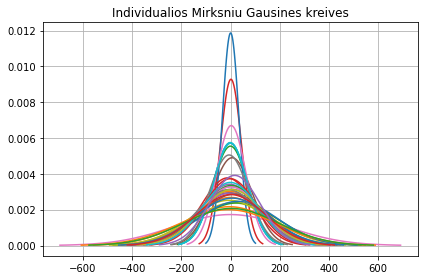

In [13]:
from scipy.stats import norm
#Piesiam grafikus kiekvieno individualaus mirksnio pagal stats.describe() funkcijos gautus duomenis
for i in range(35):
    dist = norm(combined_df.iloc[1,i], combined_df.iloc[2,i])
    x = np.linspace(combined_df.iloc[1,i] - 3*combined_df.iloc[2,i],combined_df.iloc[1,i] + 3*combined_df.iloc[2,i], 100)
    y = dist.pdf(x)
    plt.plot(x, y)
    plt.title("Individualios Mirksniu Gausines kreives")
    plt.grid(visible=True, which='major', axis='both')
    plt.tight_layout()
plt.savefig("Individualios Mirksniu Gausines kreives.png")


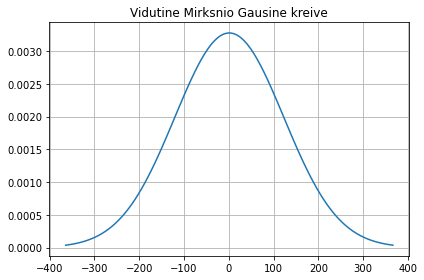

In [14]:
combined=combined_df.mean(axis=1)
#Piesiam grafika pagal vidutini mirksni pagal stats.describe() funkcijos gautus duomenis
dist = norm(combined.iloc[1], combined.iloc[2])
x = np.linspace(combined.iloc[1] - 3*combined.iloc[2],combined.iloc[1] + 3*combined.iloc[2], 100)
y = dist.pdf(x)
plt.plot(x, y)
plt.title("Vidutine Mirksnio Gausine kreive")
plt.grid(visible=True, which='major', axis='both')
plt.tight_layout()
plt.savefig("Vidutine Mirksnio Gausine kreive.png")


---
>> **UŽDUOTIS 2**
>>
>> Raumenų aktyvumo analizė (EMG)
>>
>> emg direktorijoje yra pateikti trys raumenų aktyvumo įrašai (4kHz) surinkti naudojant 25 mm adatą įsmeigtą į tiriamojo raumenį (tibialis anterior). Tiriamasis įrašo metu raumenį sutraukdavo judindamas pėdą.
>>
>> - emg_healthy.txt faile pateikti 44 metų sveiko vyro atsakai.
>> - emg_neuropathy.txt faile pateikti 64 metų vyro atsakai su chroniškais nugaros skausmais dėl L5 nervo pažaidos.
>> - emg_myopathy.txt faile pateikti 57 metų miopatija sergančio vyro  atsakai .
>> - failuose pateikta emg amplitudė (V) ir laikas (s).
>>
>> ![emg](./emg/emg.png)
>>
>> Užduotys:
>> - **Sutvarkykite ir vizualizuokite duomenis. Atkartokite pateiktą grafiką.**
>> - **Palyginkite dalyvius.**
>>
---

In [15]:
#Importuot duomenis
healthy=pd.DataFrame(pd.read_csv(r"emg/emg_healthy.csv", delimiter=";"))
myopa=pd.DataFrame(pd.read_csv(r"emg/emg_myopathy.csv", delimiter=";"))
neuropat=pd.DataFrame(pd.read_csv(r"emg/emg_neuropathy.csv", delimiter=";"))
healthy=healthy.rename(columns={'14.968070731310432':"Amplitude (mV)", '0.00025':"time"})
myopa=myopa.rename(columns={'24.99582832102417':"Amplitude (mV)", '0.00025':"time"})
neuropat=neuropat.rename(columns={'25.090357085881045':"Amplitude (mV)", '0.00025':"time"})
healthy.set_index("time")
myopa.set_index("time")
neuropat.set_index("time")

Amplitude (mV)
time                    
0.00050        25.077414
0.00075        25.077771
0.00100        25.074728
0.00125        25.073486
0.00150        25.068843
...                  ...
37.03550      191.482503
37.03580      191.483514
37.03600      191.471854
37.03630      191.474465
37.03650      191.441205

[147857 rows x 1 columns]

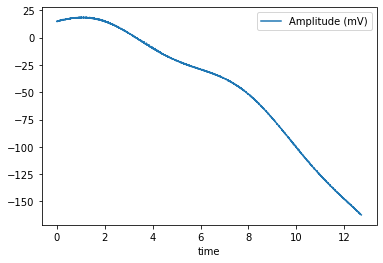

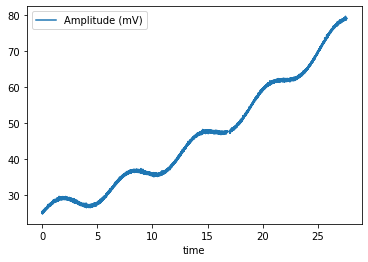

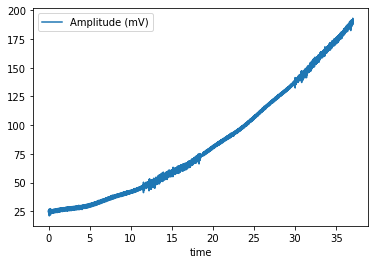

In [16]:
# Gauti grafikai - jiems reikia turbut bazine korekcija padaryt kad veiktu.
healthy.plot(x="time",y="Amplitude (mV)")
myopa.plot(x="time",y="Amplitude (mV)")
neuropat.plot(x="time",y="Amplitude (mV)")
#Signalu skaiciai ir apkirpti kad butu iki 1.5 s
neurosig=myopa["Amplitude (mV)"][1100:3000]
heasig=healthy["Amplitude (mV)"][1100:3000]
myopsig=neuropat["Amplitude (mV)"][1100:3000]
signalai=[heasig,myopsig,neurosig]

C:\Users\taura\AppData\Local\Temp\ipykernel_42404\117813509.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["",'-0.4', '- 0.2', '0', '0.2', '0.4'])
C:\Users\taura\AppData\Local\Temp\ipykernel_42404\117813509.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['-3', '-2', '-1', '0', '1',"2"])
C:\Users\taura\AppData\Local\Temp\ipykernel_42404\117813509.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(["","-1.5",'-1', '-0.5', '0', '0.5', '1'])
C:\Users\taura\AppData\Local\Temp\ipykernel_42404\117813509.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(["1",'1.1',"", '1.2',"", '1.3',"", '1.4',"", '1.5'])
C:\Users\taura\AppData\Local\Temp\ipykernel_42404\117813509.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xtickl

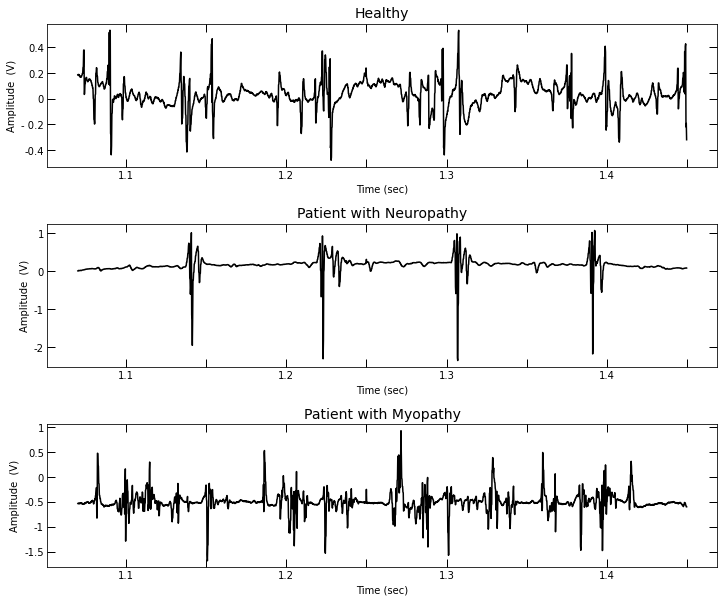

In [17]:
fig, axs = plt.subplots(3, figsize=(12, 10))
#plt.set_cmap('gray')# Ar zinot kodel sitas neveikia man ? turejau pasirinkti tesiog color black. 

#MUSU GALINGASIS GRAFIKAS - 
for i, sig in enumerate(signalai):
    drift = peakutils.baseline(sig, 2)
    x_corrected = sig - drift
    axs[i % 3].plot(x_corrected,color='black')
    axs[i % 3].set_xlabel("Time (sec)")
    axs[i % 3].set_ylabel("Amplitude  (V)")
    axs[i % 3].tick_params(axis='both', direction='in', width=1, length=8, right=True, top=True)
plt.subplots_adjust(hspace=0.4)  
#Titulai subplotu
axs[0].set_title("Healthy", fontsize=14)
axs[1].set_title("Patient with Neuropathy", fontsize=14)
axs[2].set_title("Patient with Myopathy", fontsize=14)
# x ir y asies aptvarkymai
axs[0].set_yticklabels(["",'-0.4', '- 0.2', '0', '0.2', '0.4'])
axs[1].set_yticklabels(['-3', '-2', '-1', '0', '1',"2"])
axs[2].set_yticklabels(["","-1.5",'-1', '-0.5', '0', '0.5', '1'])
axs[0].set_xticklabels(["1",'1.1',"", '1.2',"", '1.3',"", '1.4',"", '1.5'])
axs[1].set_xticklabels(["1",'1.1',"", '1.2',"", '1.3',"", '1.4',"", '1.5'])
axs[2].set_xticklabels(["1",'1.1',"", '1.2',"", '1.3',"", '1.4',"", '1.5'])
plt.savefig("2 Uzduotis.png")

In [18]:
#DUOMENYS SUMAISYTI TARP MYOPATHY ir NEUROPATijos
#GRAFIKAS BAIGTAS - LIKO ANALIZE

In [19]:
#Patogumo delei vel pasidarom 
drift = peakutils.baseline(heasig, 2)
hea_corrected = sig - drift
drift = peakutils.baseline(myopsig, 2)
myo_corrected = sig - drift
drift = peakutils.baseline(neurosig, 2)
neur_corrected = neurosig - drift    

In [20]:
#naudojame describe kad gautume esmines savybes
neur=pd.DataFrame(neur_corrected.describe())
myo=pd.DataFrame(myo_corrected.describe())
hea=pd.DataFrame(hea_corrected.describe())
combined_emg = pd.concat([neur,myo,hea],axis=1)
combined_emg.columns=["Neuropathy", "Myopathy", "Healthy"]

In [21]:
#STATISTIKA KURIA GALIME REMTIS DARANT ISVADAS
combined_emg

Neuropathy     Myopathy      Healthy
count  1.900000e+03  1900.000000  1900.000000
mean  -4.764002e-14     1.061421     9.317490
std    8.130209e-02     0.247015     0.122811
min   -4.746887e-01     0.347149     8.818575
25%   -2.299339e-02     0.879343     9.236104
50%   -4.948711e-03     1.100276     9.288455
75%    1.928155e-02     1.271056     9.394927
max    5.728292e-01     1.716638     9.915146

In [22]:
#Isvados
print( "Pirma galime pastebeti Myopathy signalo aukštą std - 0.3279, tai nurodo signalo nestabilumą - aukštą variaciją. Tai sutampa su myopatijos simptomais. Degeneruojantis raumeninis audinys ir ")
print("nekontroliuojami spazmai. Taip pat galima pastebėti kad signalo vidurkis yra mažesnis - Tai taip pat nurodo signalo stiprumo sumažėjimą. Neuropatijos signale matome labai aukštą maksimalią signalo vertę")
print("Tikėtina kad pažeistam nervui norint nusiųsti signalą, neužtenka standartinio neuromediatorių inputo ir signalas overshootina. Taip pat matome, tiksliau nematome variacijos signale ramybės būsenoje" )     

Pirma galime pastebeti Myopathy signalo aukštą std - 0.3279, tai nurodo signalo nestabilumą - aukštą variaciją. Tai sutampa su myopatijos simptomais. Degeneruojantis raumeninis audinys ir 
nekontroliuojami spazmai. Taip pat galima pastebėti kad signalo vidurkis yra mažesnis - Tai taip pat nurodo signalo stiprumo sumažėjimą. Neuropatijos signale matome labai aukštą maksimalią signalo vertę
Tikėtina kad pažeistam nervui norint nusiųsti signalą, neužtenka standartinio neuromediatorių inputo ir signalas overshootina. Taip pat matome, tiksliau nematome variacijos signale ramybės būsenoje


---
>> **UŽDUOTIS 3**
>>
>> Raumenų aktyvumo analizė (EMG)
>>
>> Tiriamieji ranka atliko 19 skirtingų judesių. Tuo pat metu fiksuotas riešo raumenų aktyvumas - 8 kanalų EMG. Diskretizacijos dažnis 250 Hz.
>>
>> 10 EMG įrašų csv formatu emg2 direktorijoje.
>>
>> Duomenys:
>> - time: laikas sekundėmis
>> - condition: judesio tipas
>> - epoch: stimulo eilės numeris eksperimente
>> - ch1-ch8: EMG kanalai ($\mu V$)
>>
>>
>> Užduotys:
>> - **Sutvarkykite ir vizualizuokite signalus.**
>> - **Palyginkite skirtingus judesius.**
>> - **Palyginkite judesius tarp dalyvių.**
>>
>>
---

In [23]:
#Duomenis isikeliame naudodamiesi pakeistu DUOMETRONU !!
directory=r"C:\Users\taura\Documents\biod2022\exam\K6\emg2"
dataframes = {}
def duometronas1(directory=directory):
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            df = pd.DataFrame(pd.read_csv(file_path, index_col=1))
            dataframes[file] = df
            
duometronas1()

In [24]:
 # Velensniuose duomenyse matome kad ketvirtas kanalas pilnas triuksmo tai tesiog ismetame ji
for name in dataframes:
    dataframes[name] = dataframes[name].drop('ch4', axis=1)

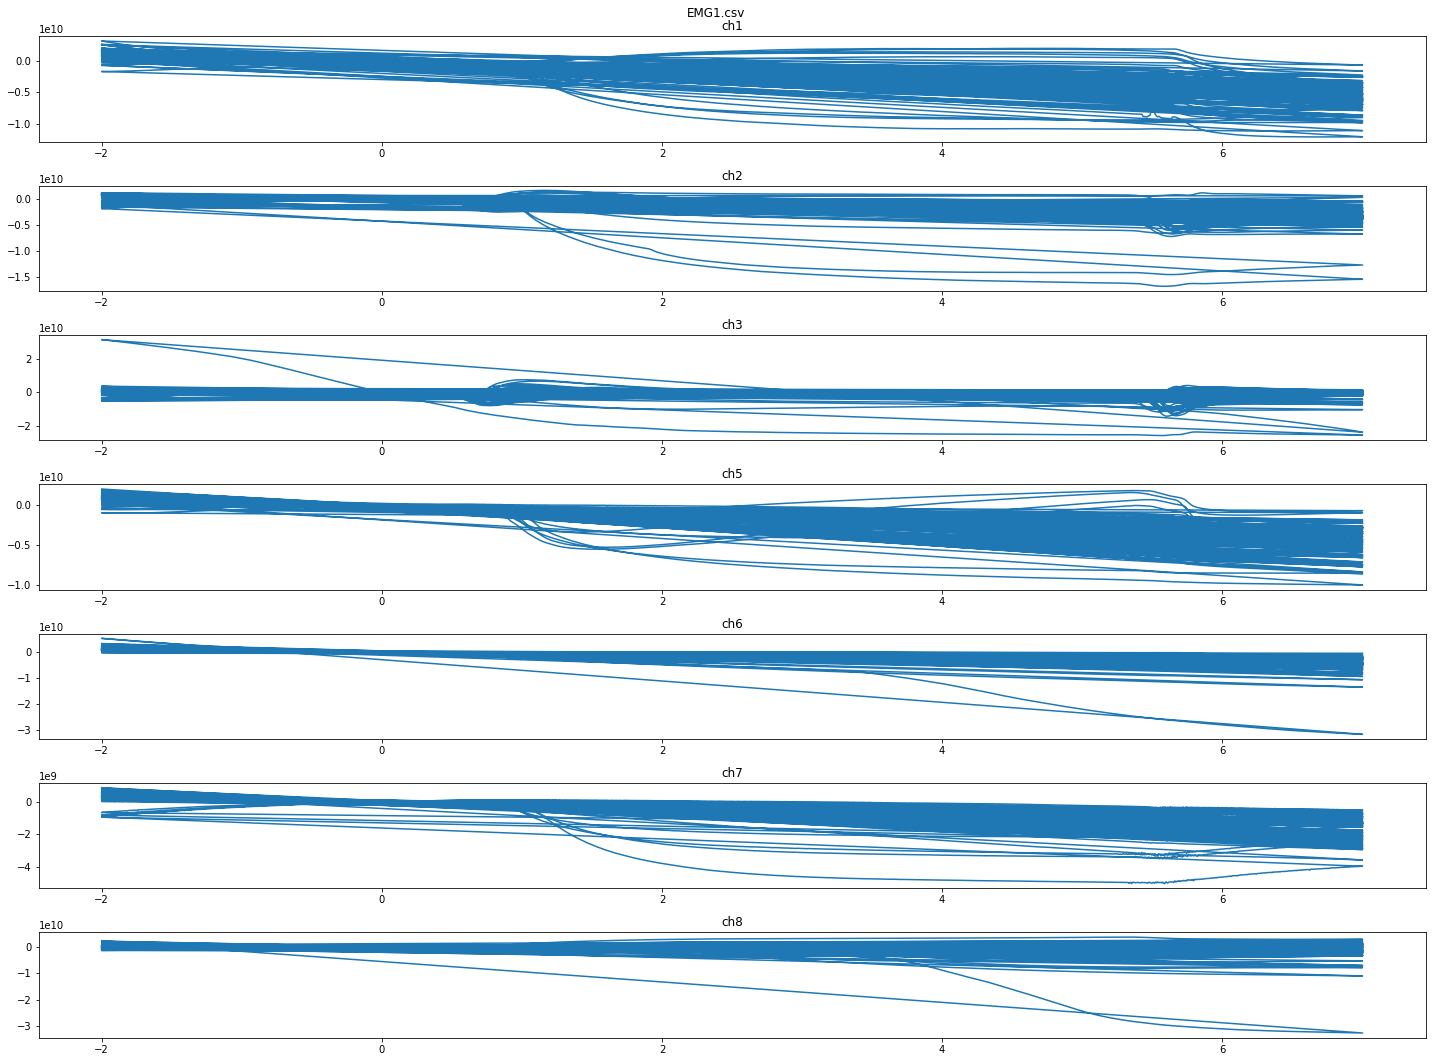

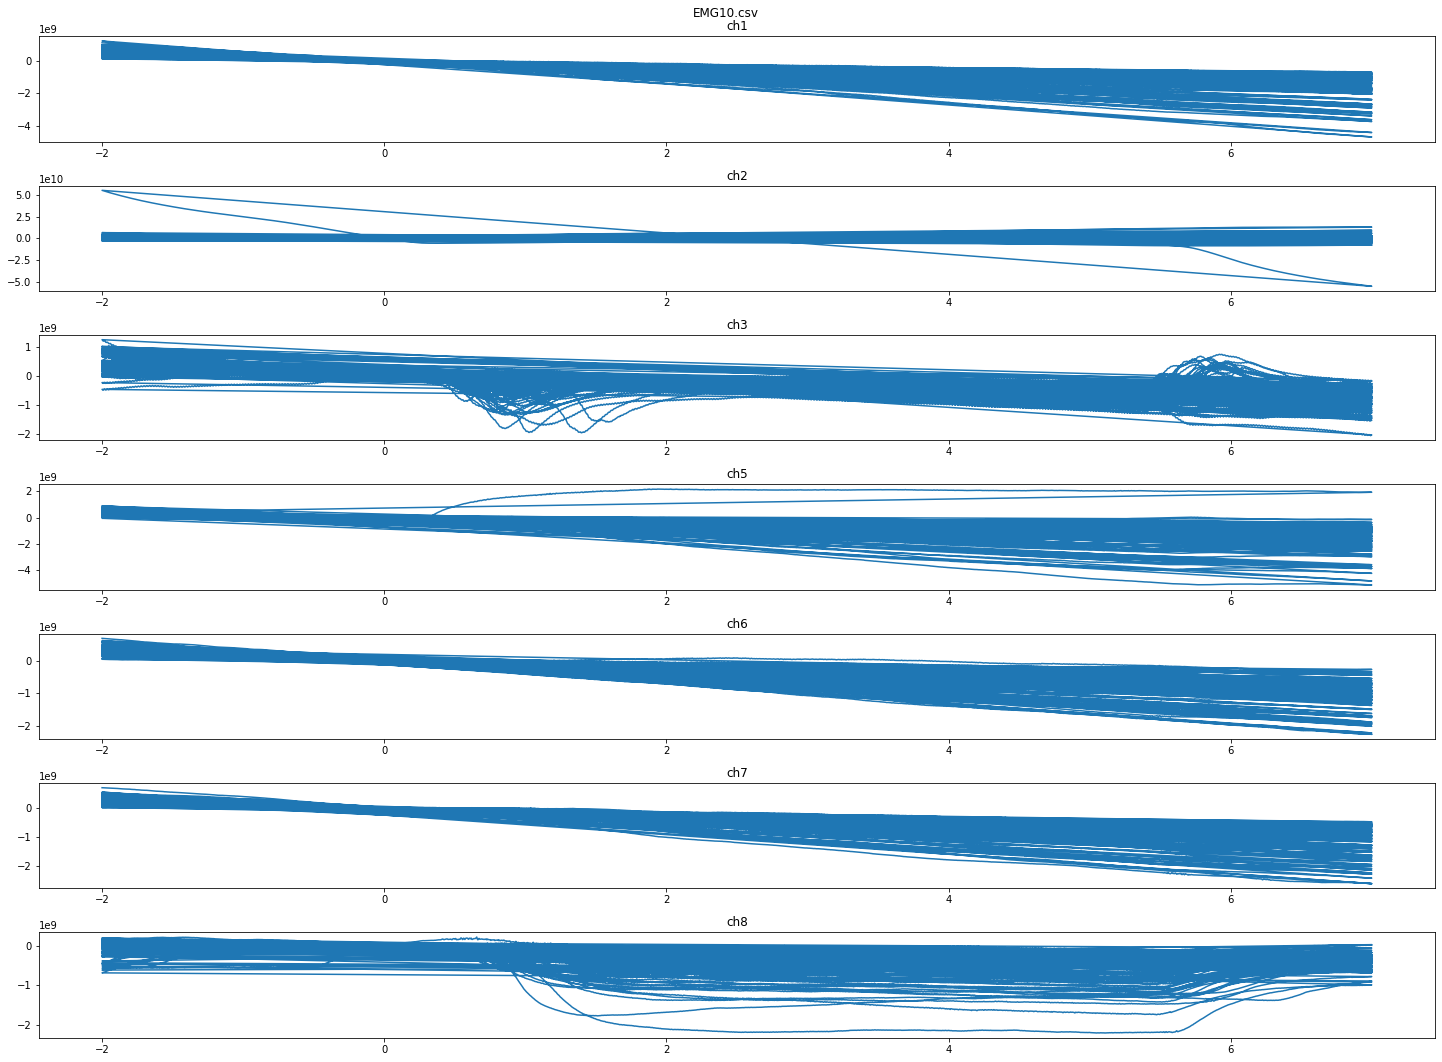

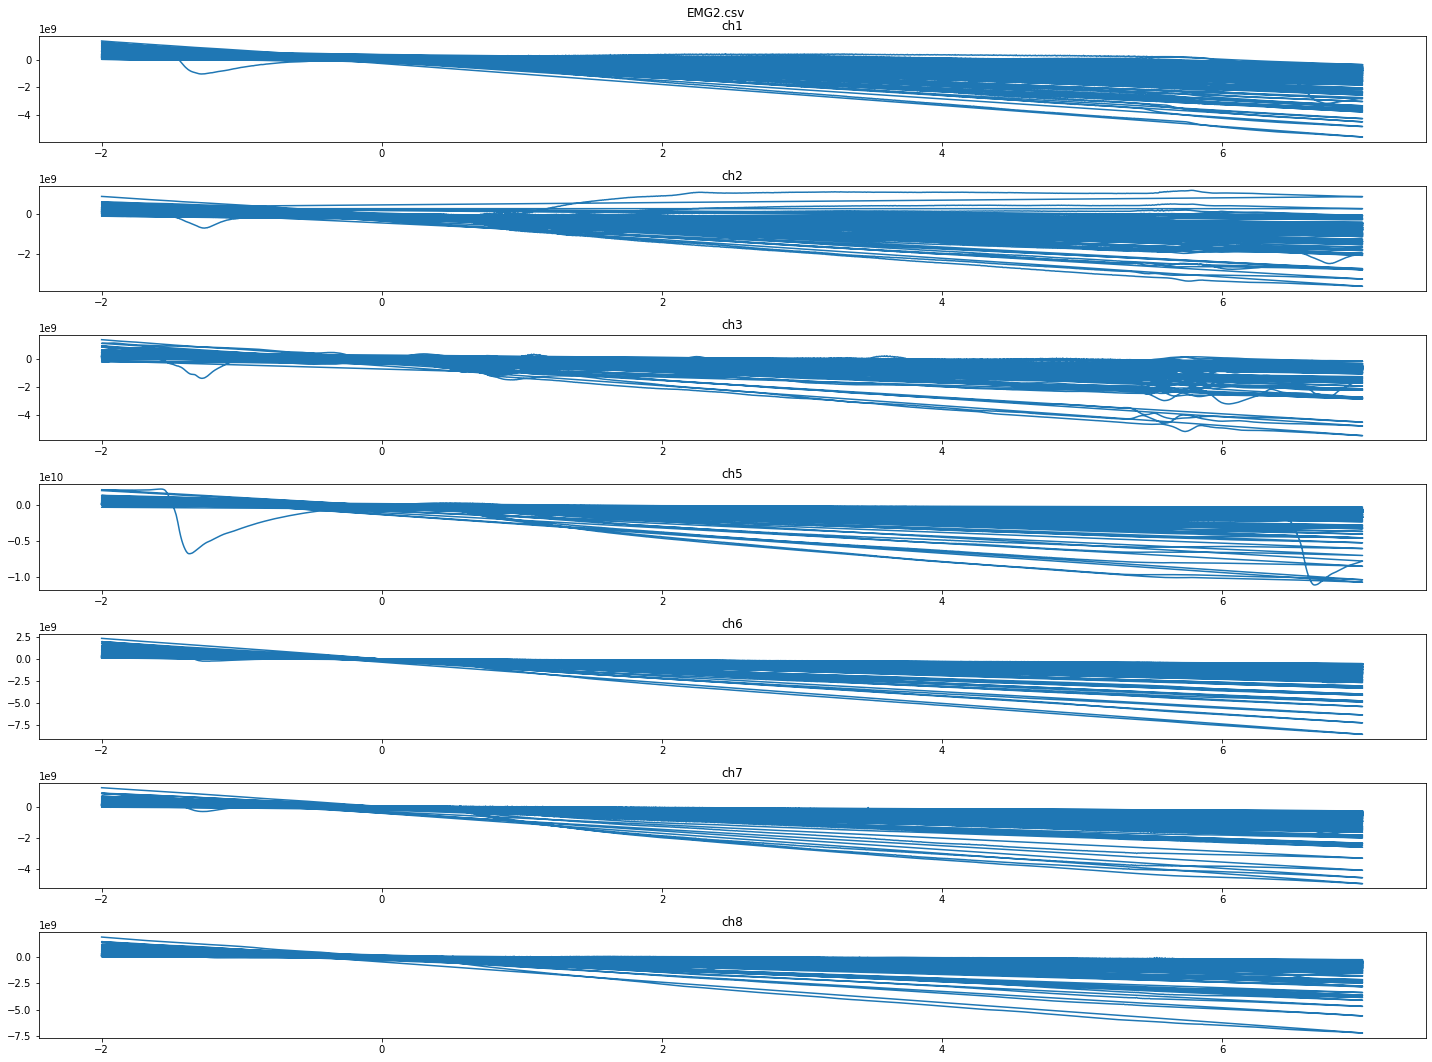

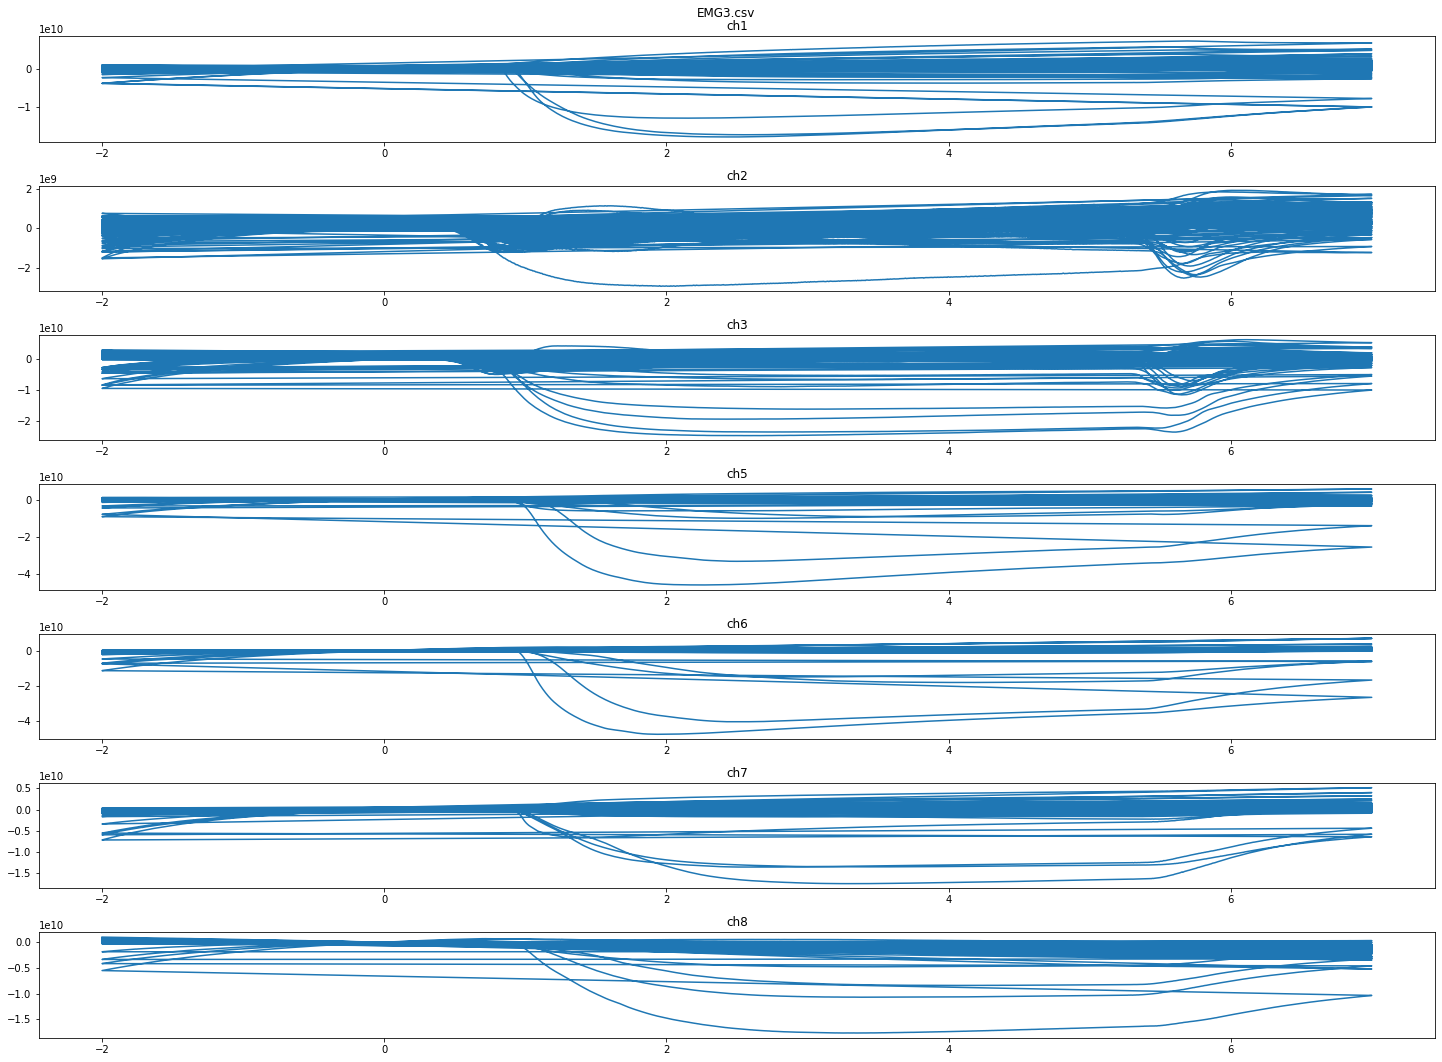

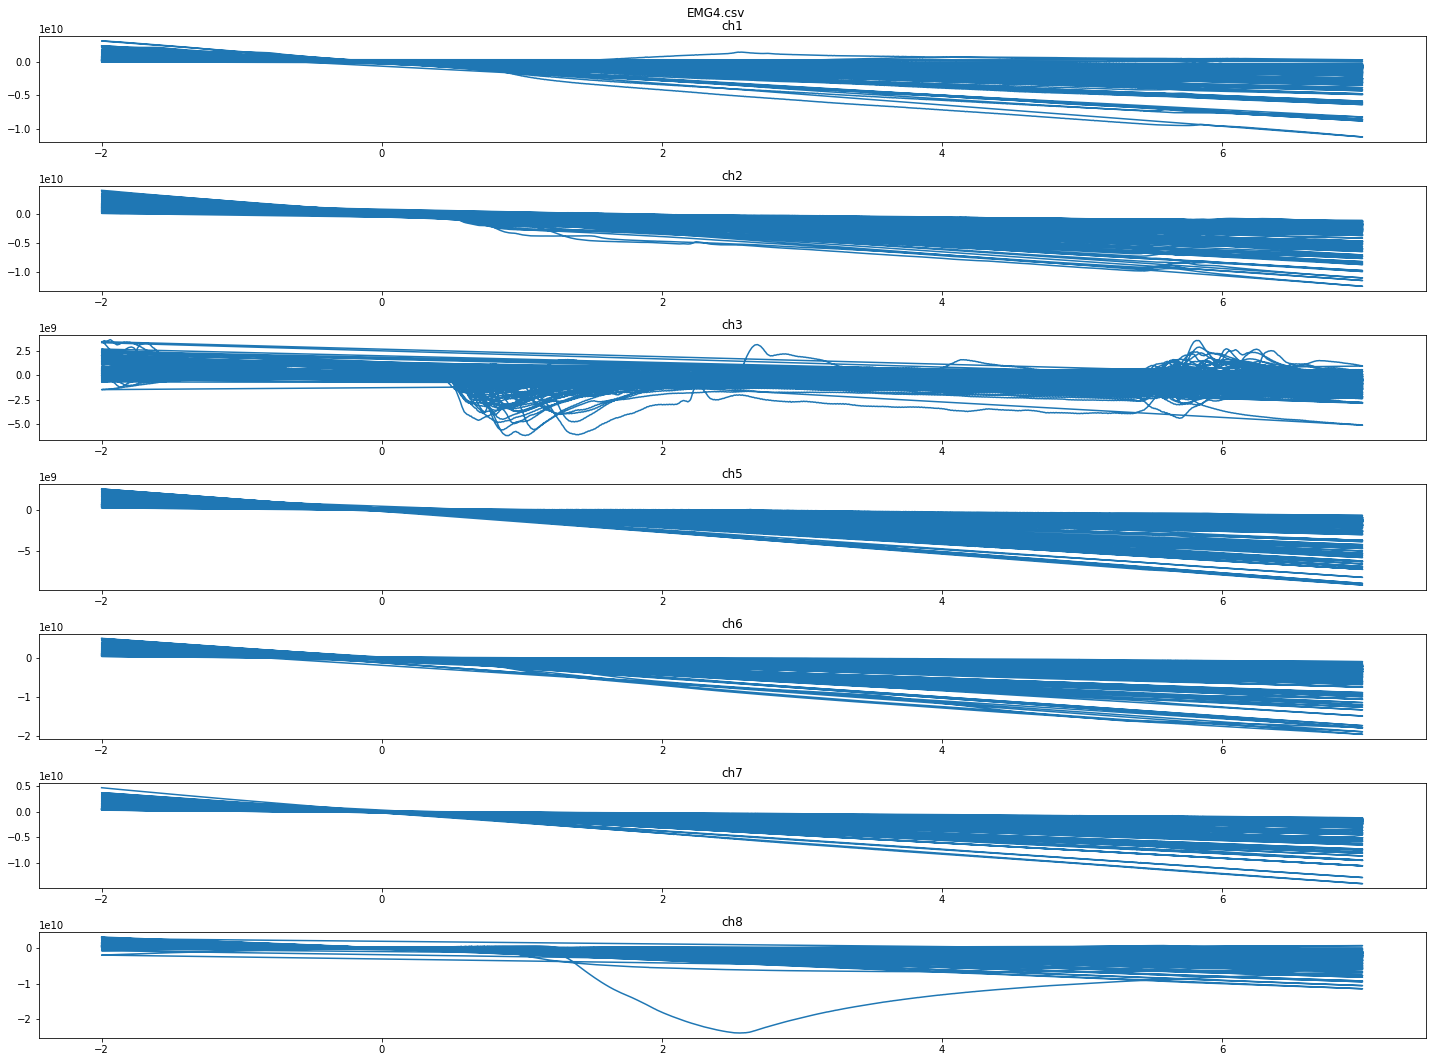

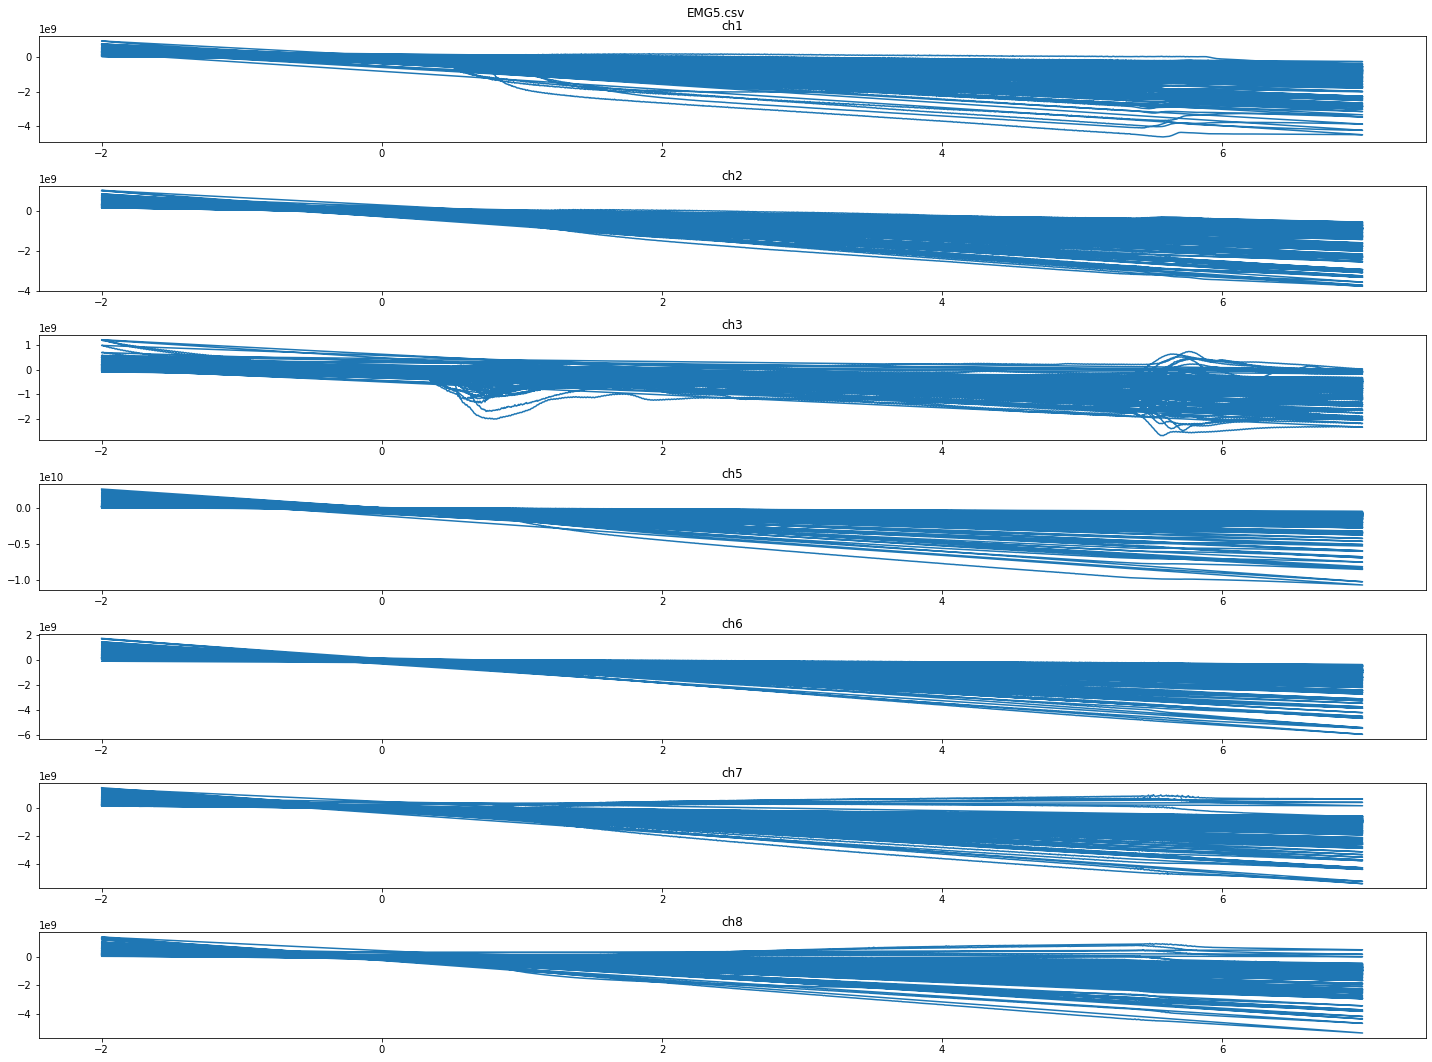

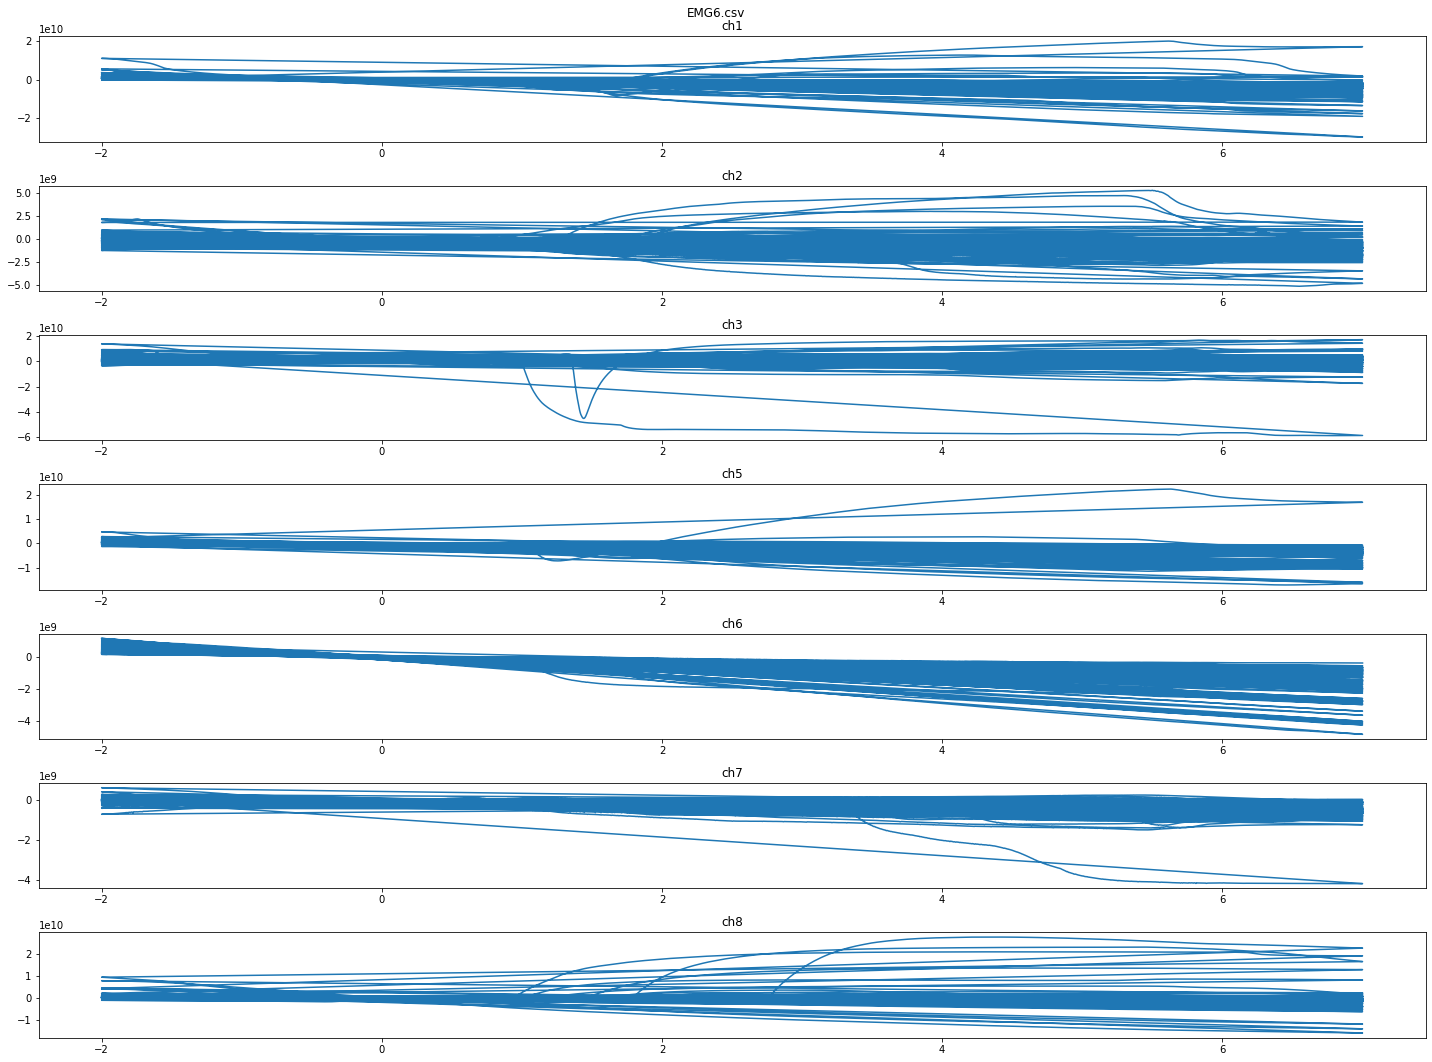

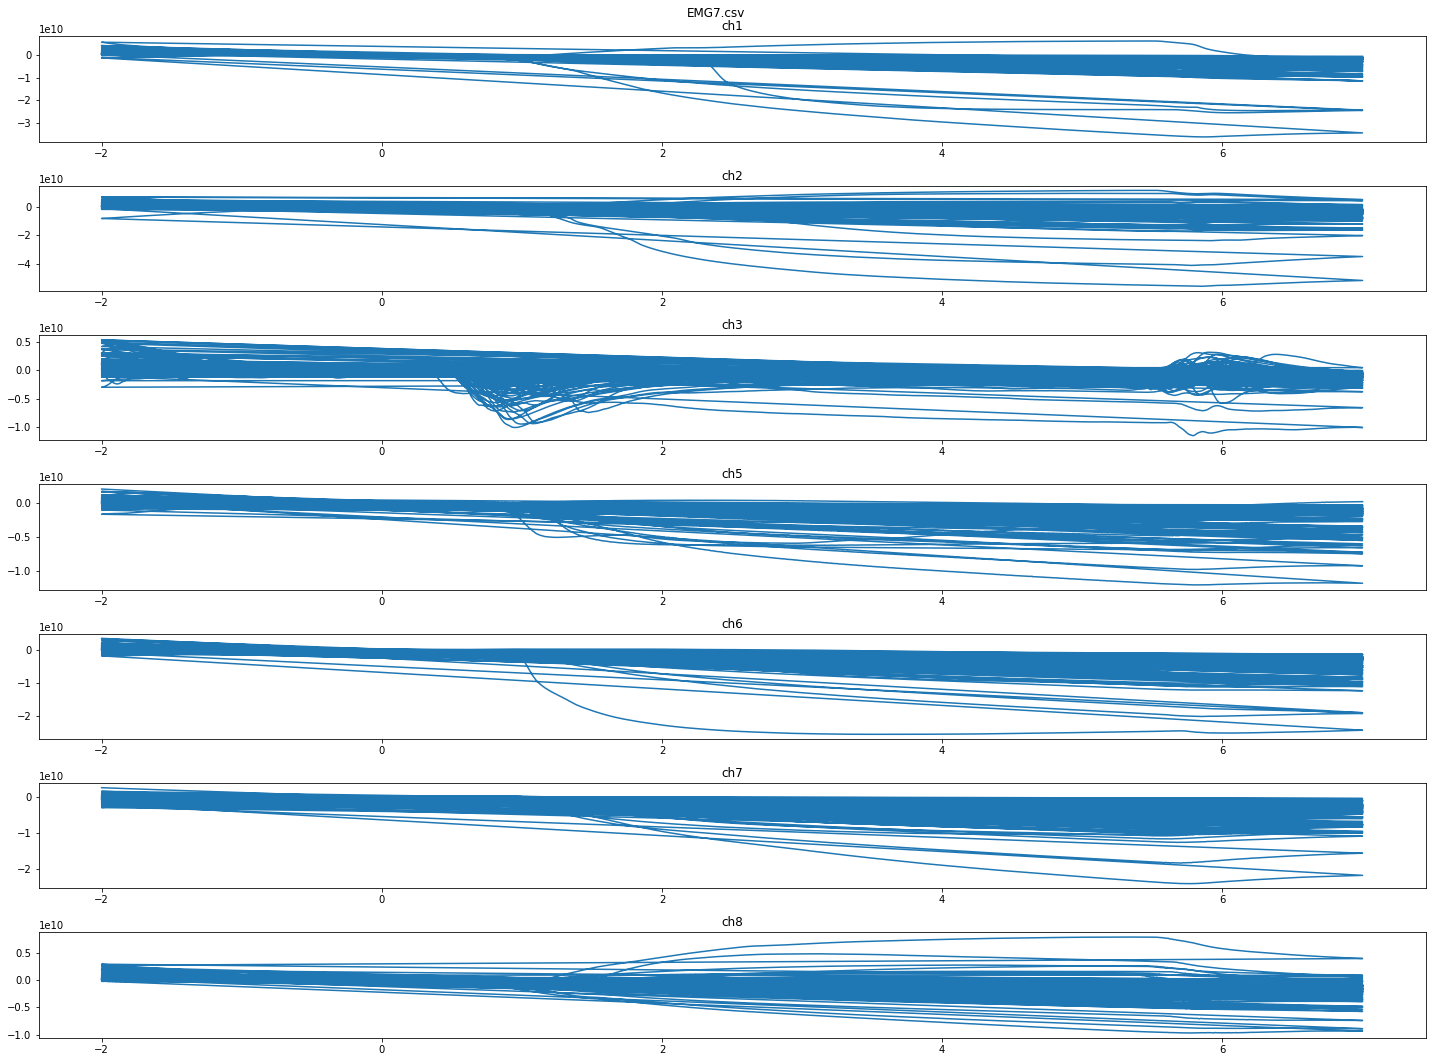

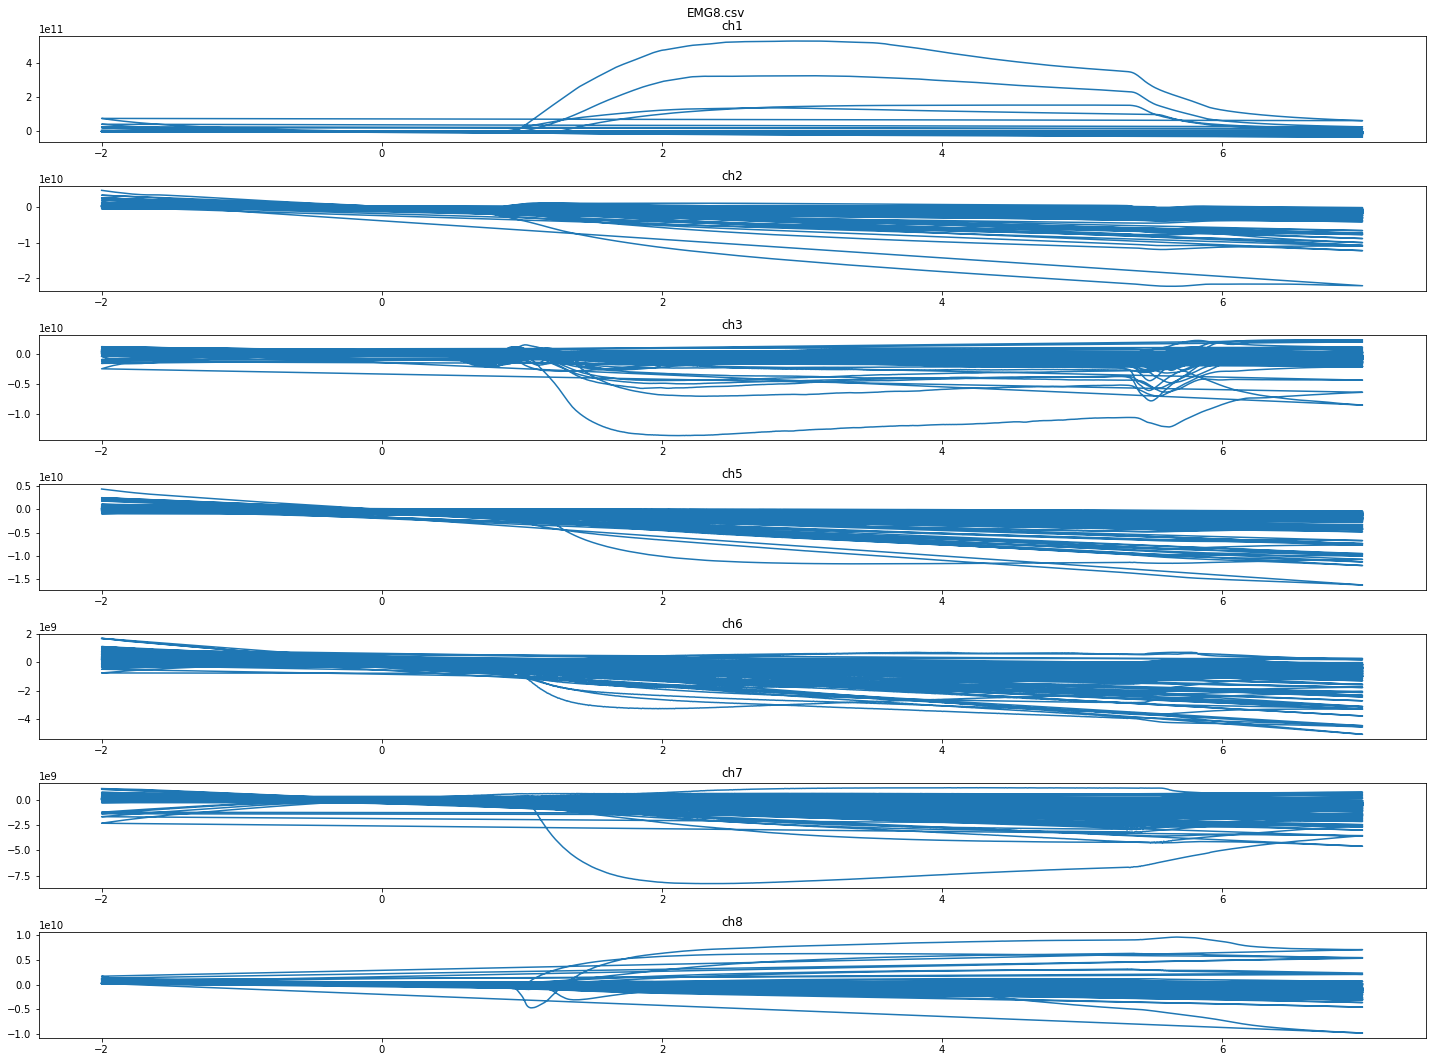

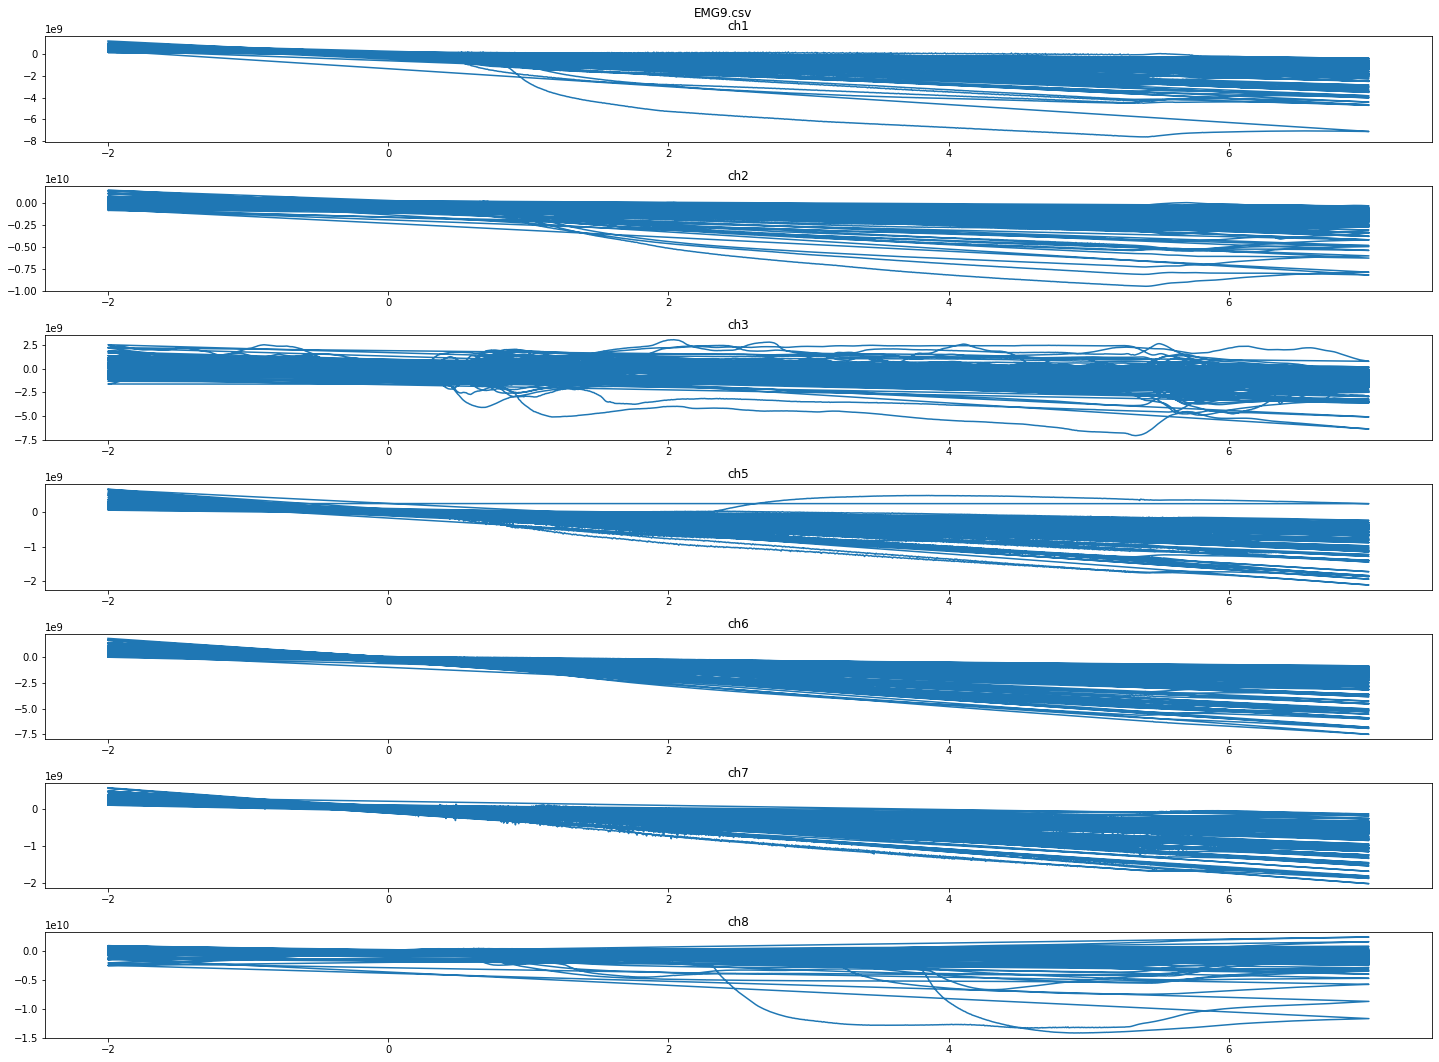

In [25]:
#Vizualizuoti signalai
for name in dataframes:
    fig, axes = plt.subplots(nrows=len(dataframes[name].columns)-3, figsize=(20, 15))
    fig.suptitle(name)
    for i, col in enumerate(dataframes[name].columns[3:]):
        axes[i].plot(dataframes[name][col])
        axes[i].set_title(col)
    plt.tight_layout()
    plt.show()

In [26]:
#Analizuojant skirtumus tarp judesiu galime sujungti visus duomenis i viena lentele ir tada grupuoti pagal conditiona
combined = pd.concat(dataframes, axis=0)

In [27]:
#For ciklui gauname visu judesiu pavadinimus
judesiu_sarasas = set(combined['condition'].tolist())
judesiu_sarasas


{'3_FINGERS',
 'DOWN',
 'FIST_DOWN',
 'FIST_UP',
 'GRAB',
 'L',
 'LEFT',
 'OK',
 'PEACE',
 'POINTING',
 'RELEASE',
 'REST',
 'RIGHT',
 'SATAN',
 'SHOOTING',
 'THUMB_90',
 'THUMB_UP',
 'UP',
 'ZOOM_1'}

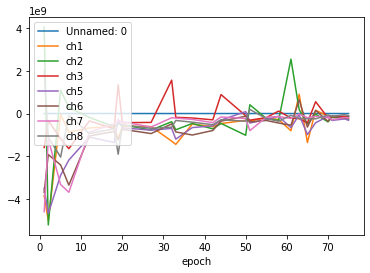

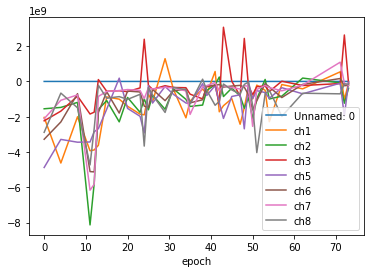

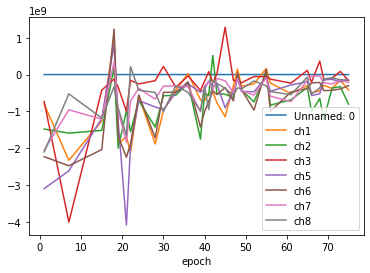

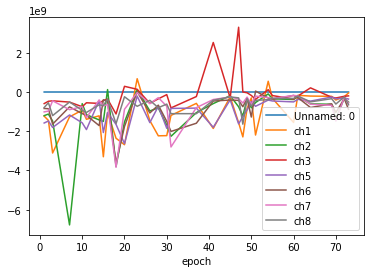

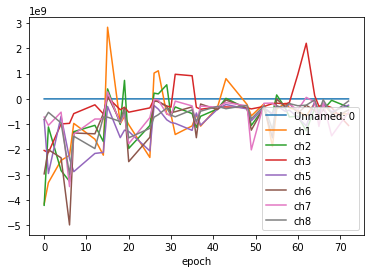

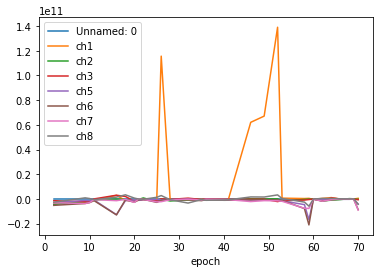

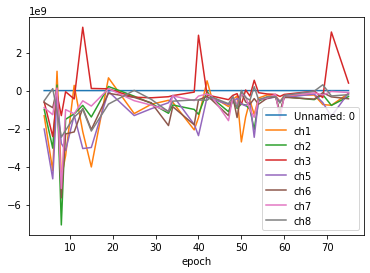

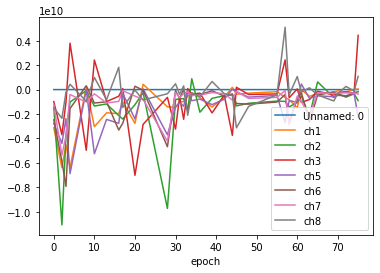

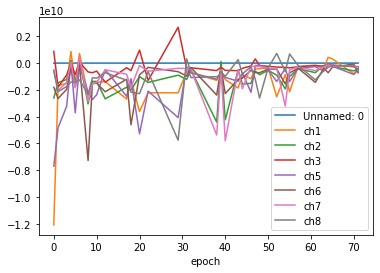

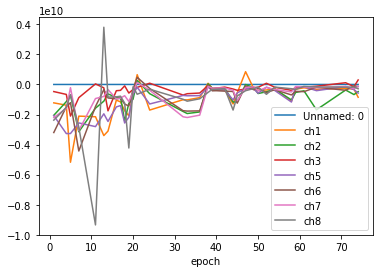

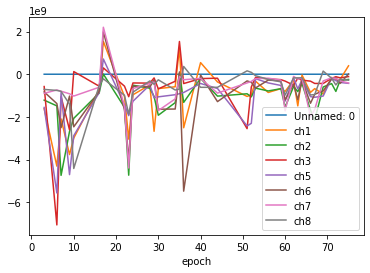

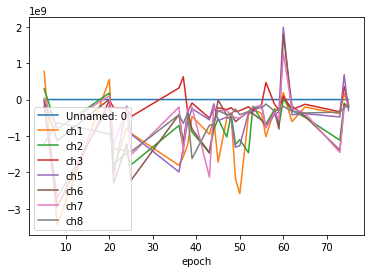

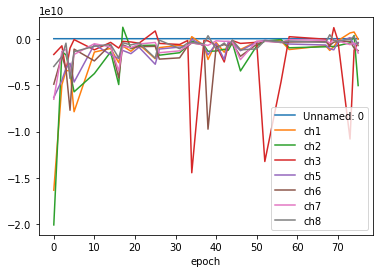

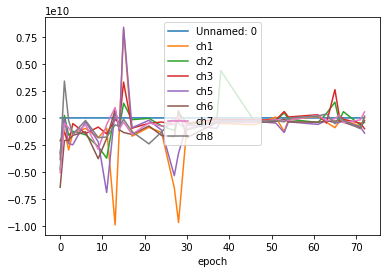

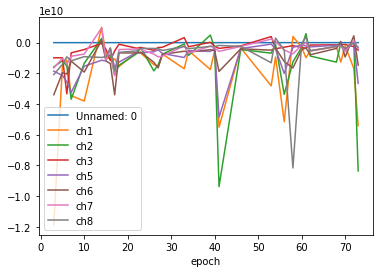

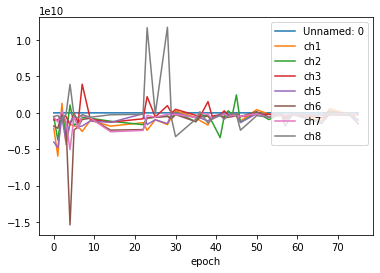

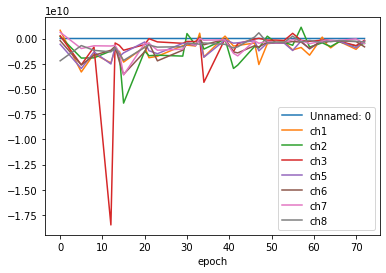

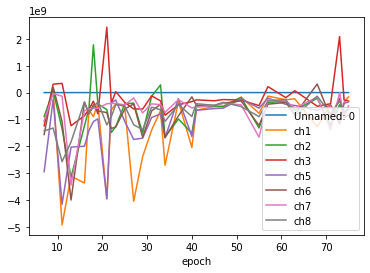

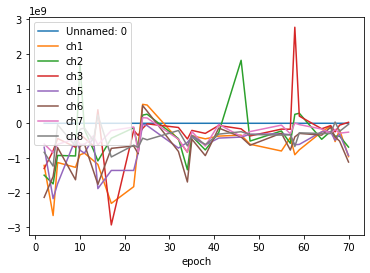

In [28]:
#Pavaizduojame ir galime palyginti kiekvieno signalo kanalo suvidurkintus rodmenis/
judesiai = {}
for jude in judesiu_sarasas:
    judesiai[jude] = combined[combined['condition'] == jude].groupby('epoch').mean().plot()

In [29]:
judesiai

{'THUMB_UP': <AxesSubplot:xlabel='epoch'>,
 'LEFT': <AxesSubplot:xlabel='epoch'>,
 'ZOOM_1': <AxesSubplot:xlabel='epoch'>,
 'PEACE': <AxesSubplot:xlabel='epoch'>,
 'L': <AxesSubplot:xlabel='epoch'>,
 'FIST_UP': <AxesSubplot:xlabel='epoch'>,
 'SHOOTING': <AxesSubplot:xlabel='epoch'>,
 'UP': <AxesSubplot:xlabel='epoch'>,
 'RELEASE': <AxesSubplot:xlabel='epoch'>,
 'POINTING': <AxesSubplot:xlabel='epoch'>,
 'THUMB_90': <AxesSubplot:xlabel='epoch'>,
 'SATAN': <AxesSubplot:xlabel='epoch'>,
 'RIGHT': <AxesSubplot:xlabel='epoch'>,
 'FIST_DOWN': <AxesSubplot:xlabel='epoch'>,
 'DOWN': <AxesSubplot:xlabel='epoch'>,
 'GRAB': <AxesSubplot:xlabel='epoch'>,
 'OK': <AxesSubplot:xlabel='epoch'>,
 '3_FINGERS': <AxesSubplot:xlabel='epoch'>,
 'REST': <AxesSubplot:xlabel='epoch'>}

In [30]:
# Padariau kiek galejau, nuosirdziai stengiausi. Manau tarp tiriamuju duomenys judesiu skirias. Ir nesaugojau kiekvieno grafiko nes butu absoliutus spamus tai dedu tik pagrindius pirmos ir antros uzduoties.